In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [4]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = int(retina_width//photoreceptor_width)
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [5]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [6]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))

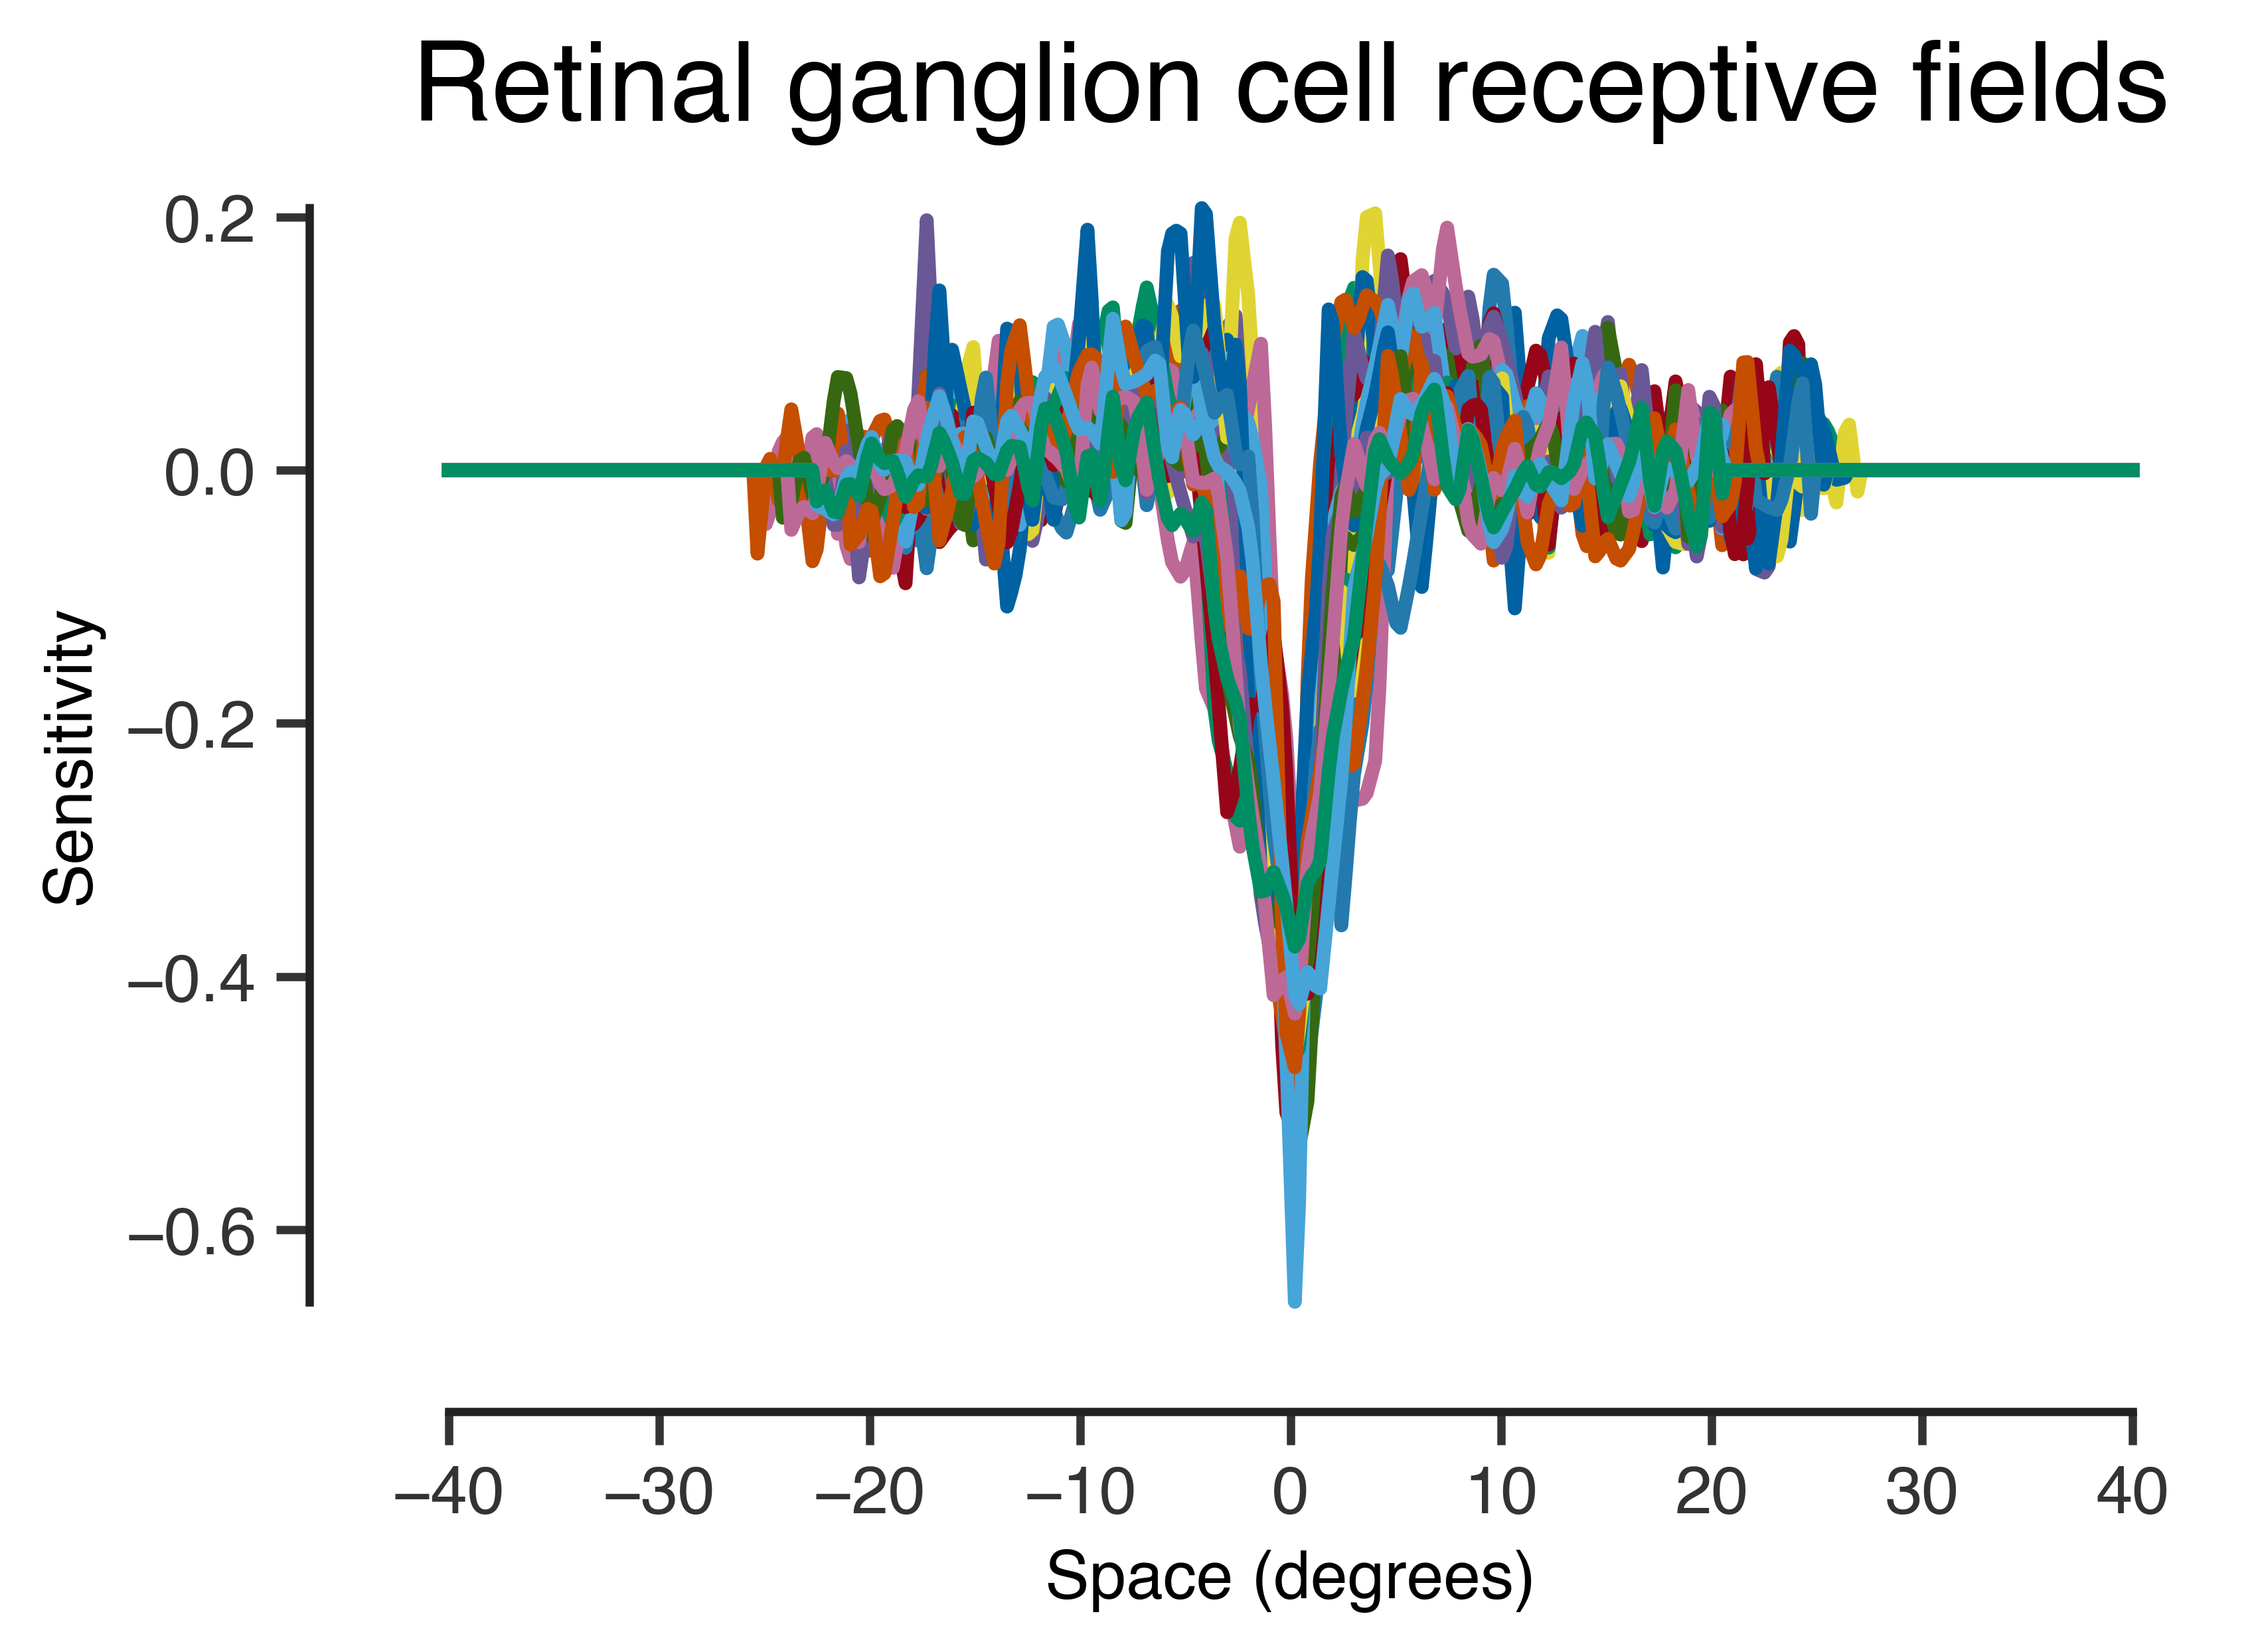

In [7]:
for c in receptive_fields['ganglion']:
    plt.plot(space, c)
plt.xlabel('Space (degrees)')
plt.ylabel('Sensitivity')
plt.title('Retinal ganglion cell receptive fields')
adjust_spines(plt.gca())

Average retinal ganglion cell receptive field

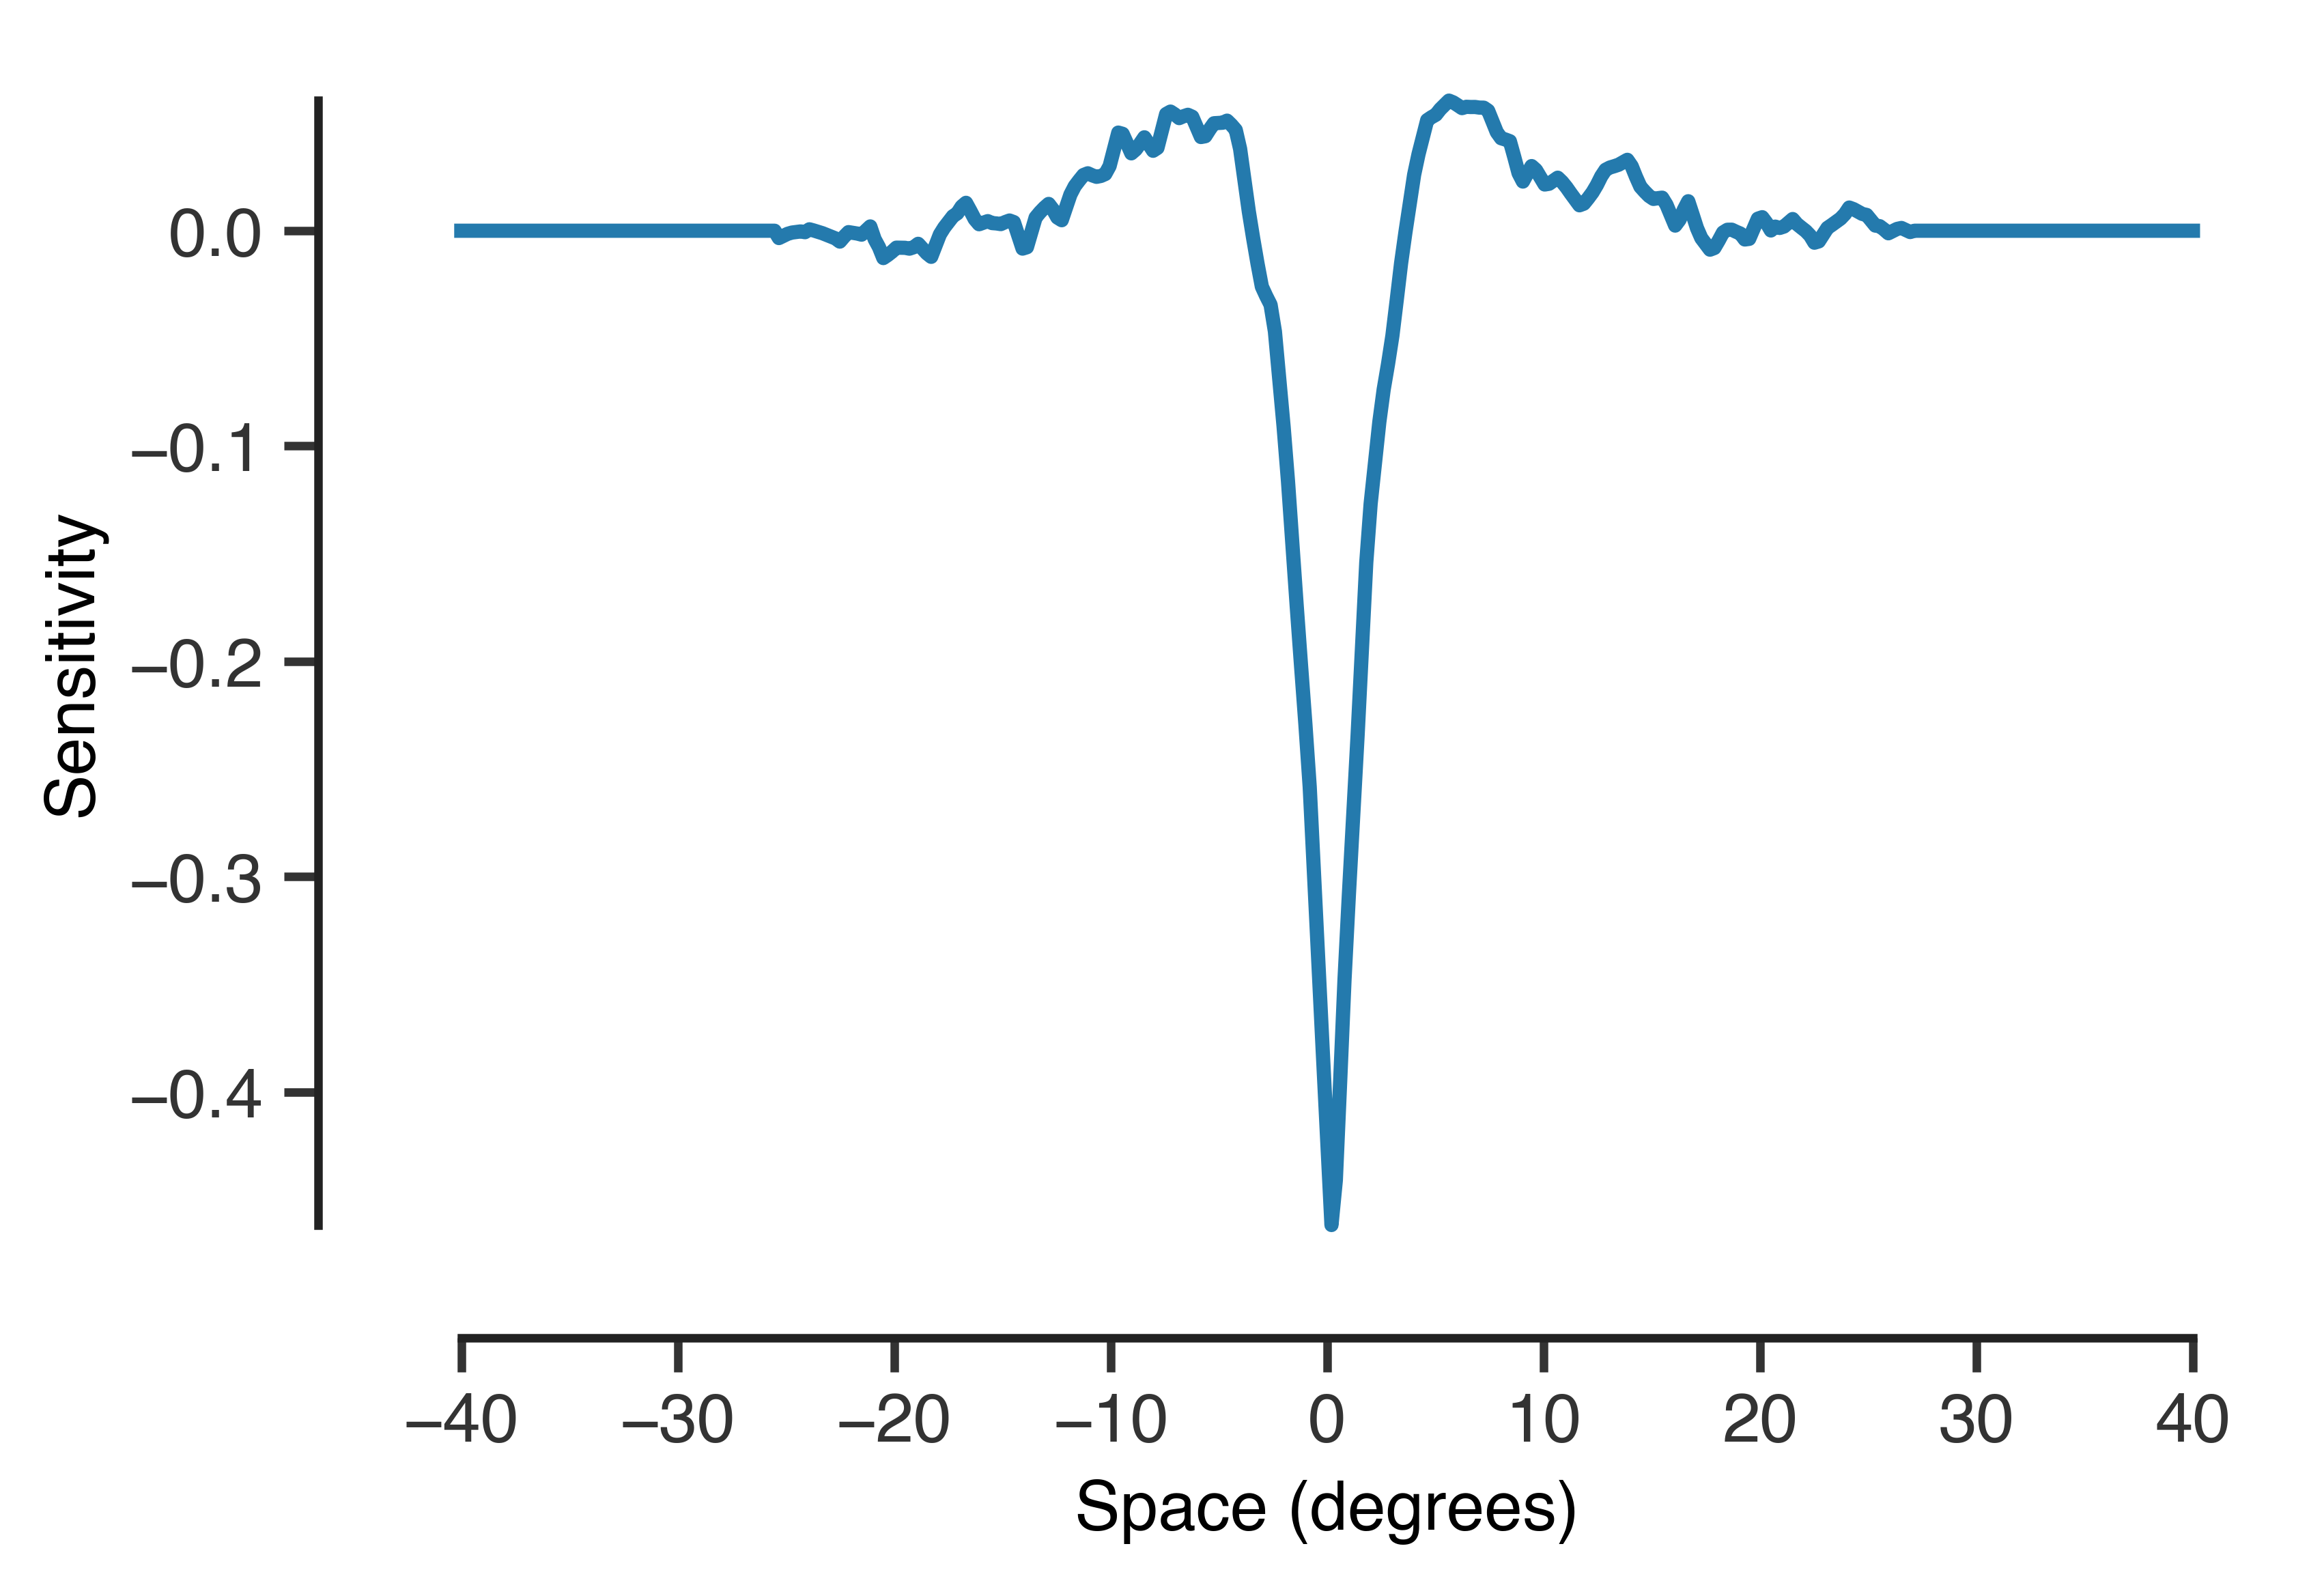

In [8]:
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)
plt.plot(space, average_ganglion_rf)
plt.ylabel('Sensitivity')
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

### Compute projective fields

In [9]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

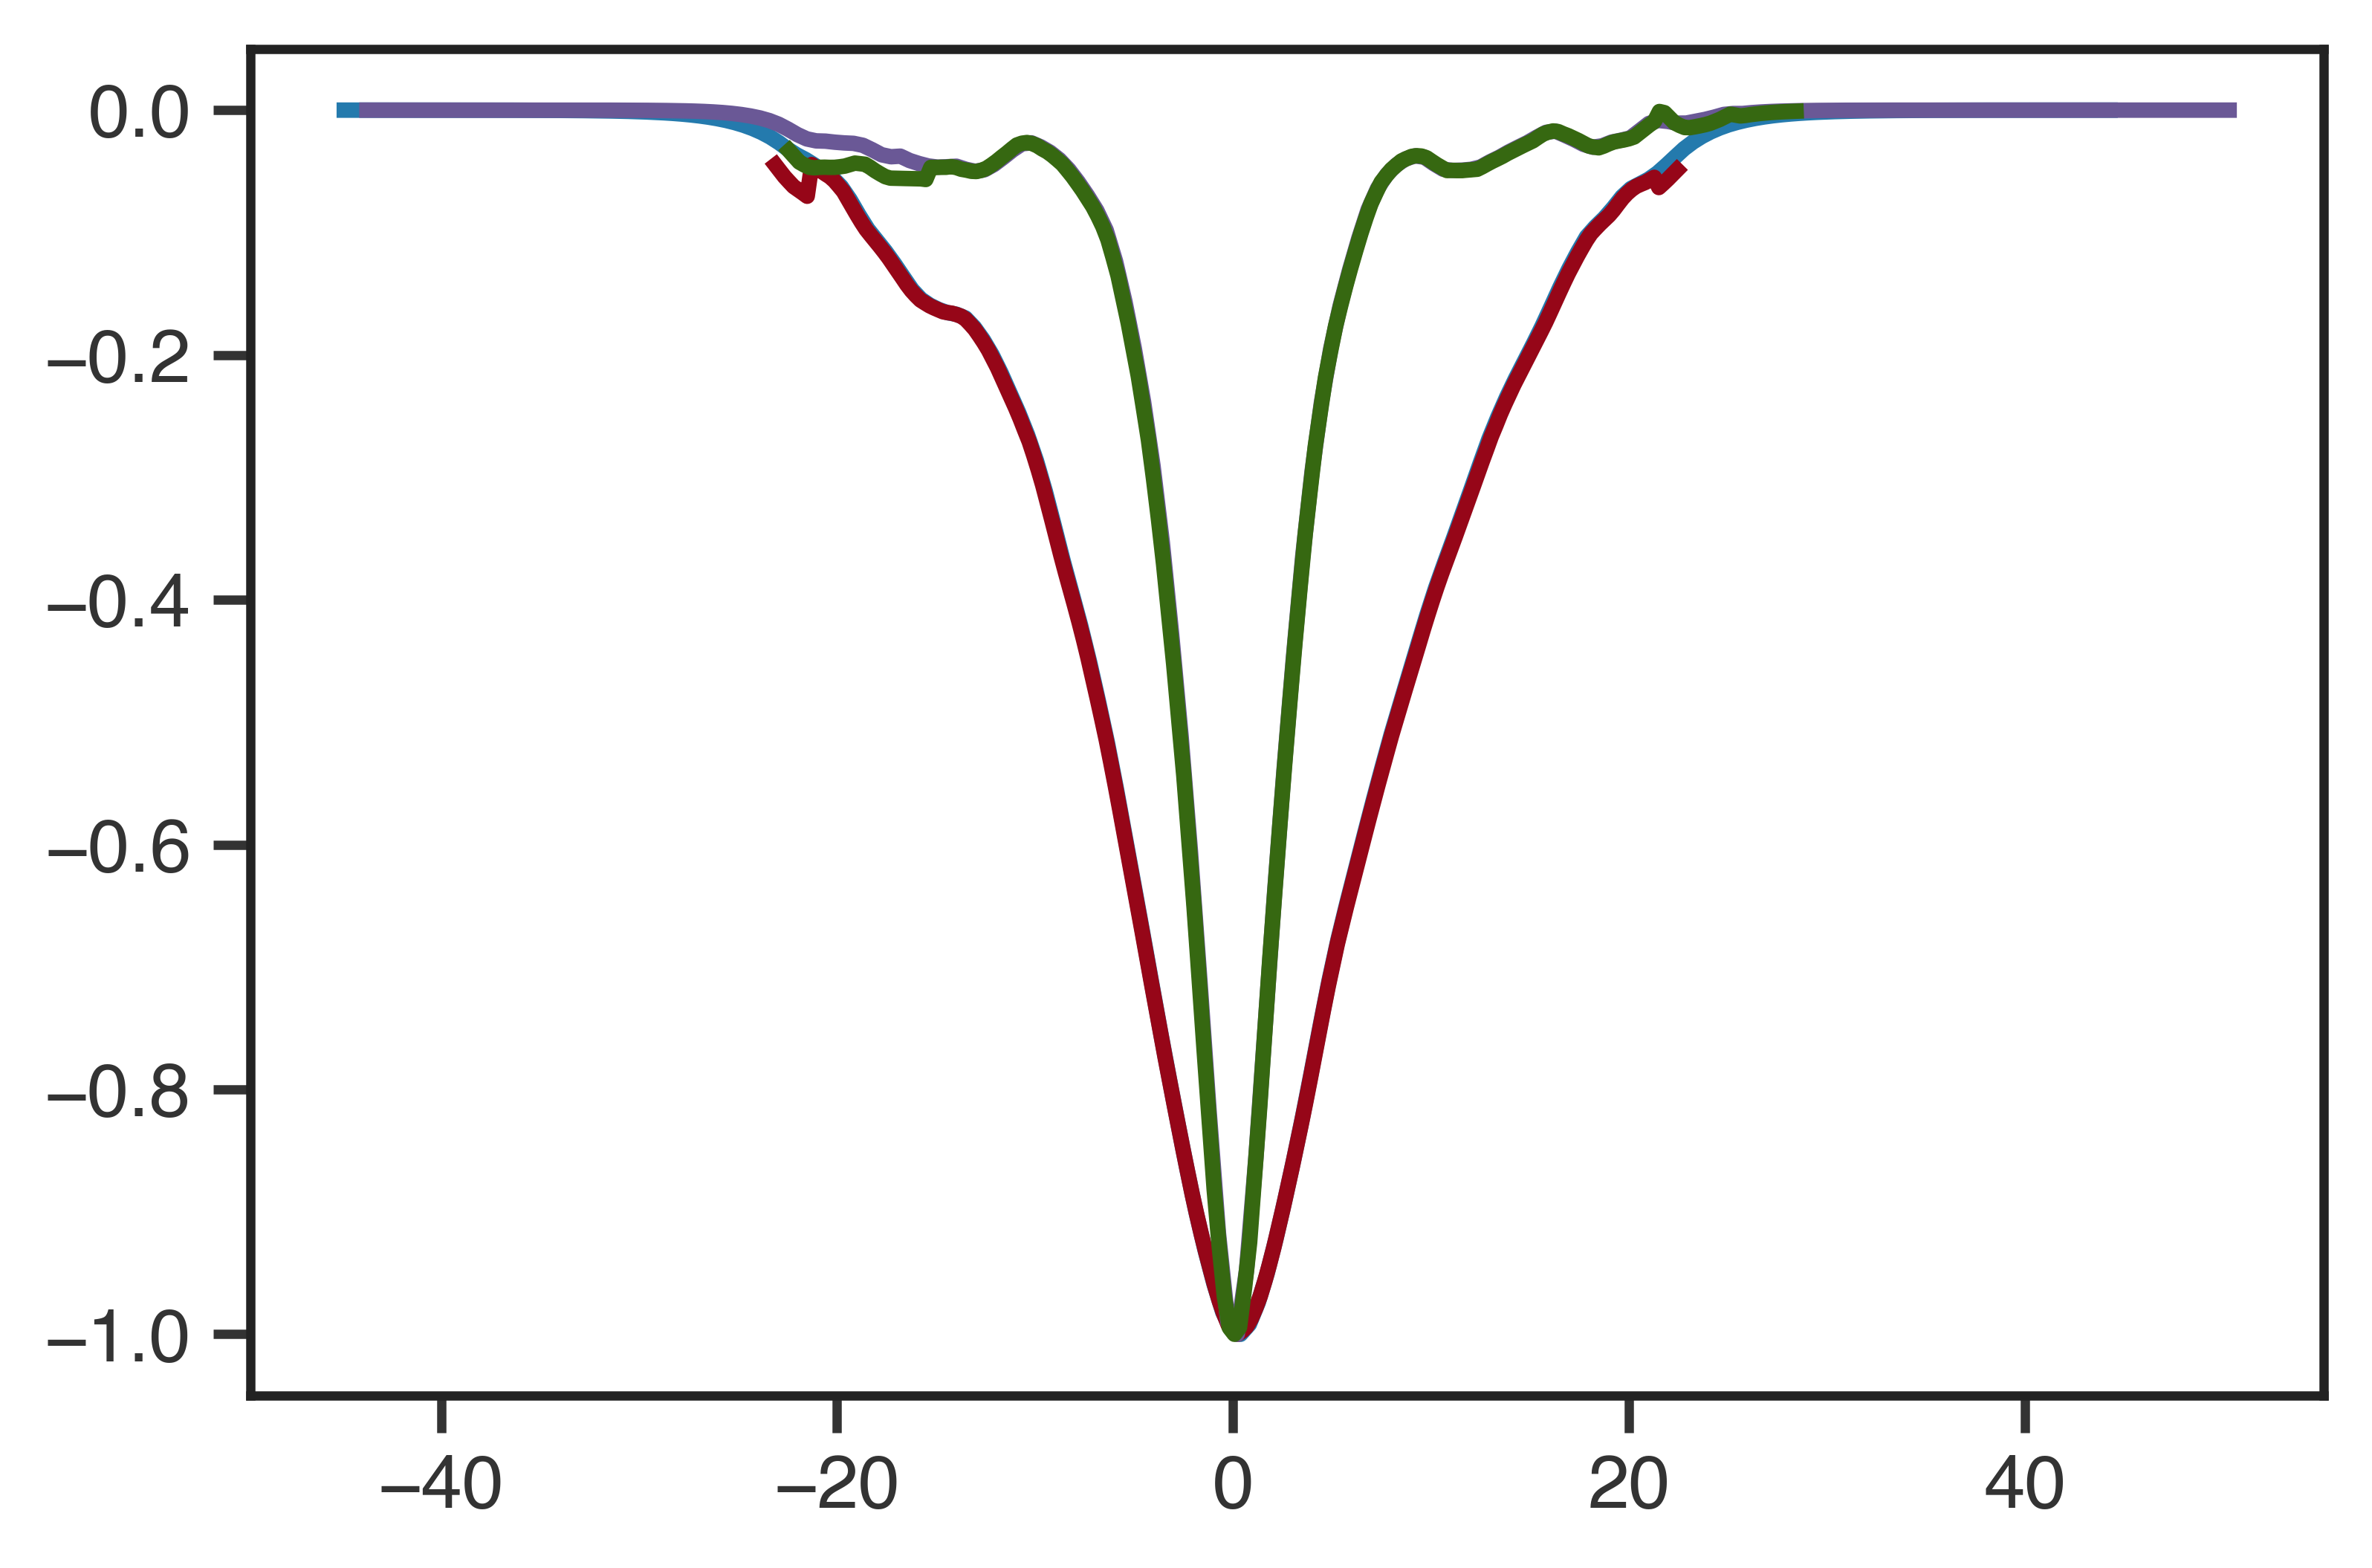

In [10]:
plt.plot(space_h_full, horz_pf_full/np.max(abs(horz_pf_full)))
plt.plot(space_h_same, horz_pf_same/np.max(abs(horz_pf_same)))
plt.plot(space_a_full, ama_pf_full/np.max(abs(ama_pf_full)))
plt.plot(space_a_same, ama_pf_same/np.max(abs(ama_pf_same)))

In [11]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

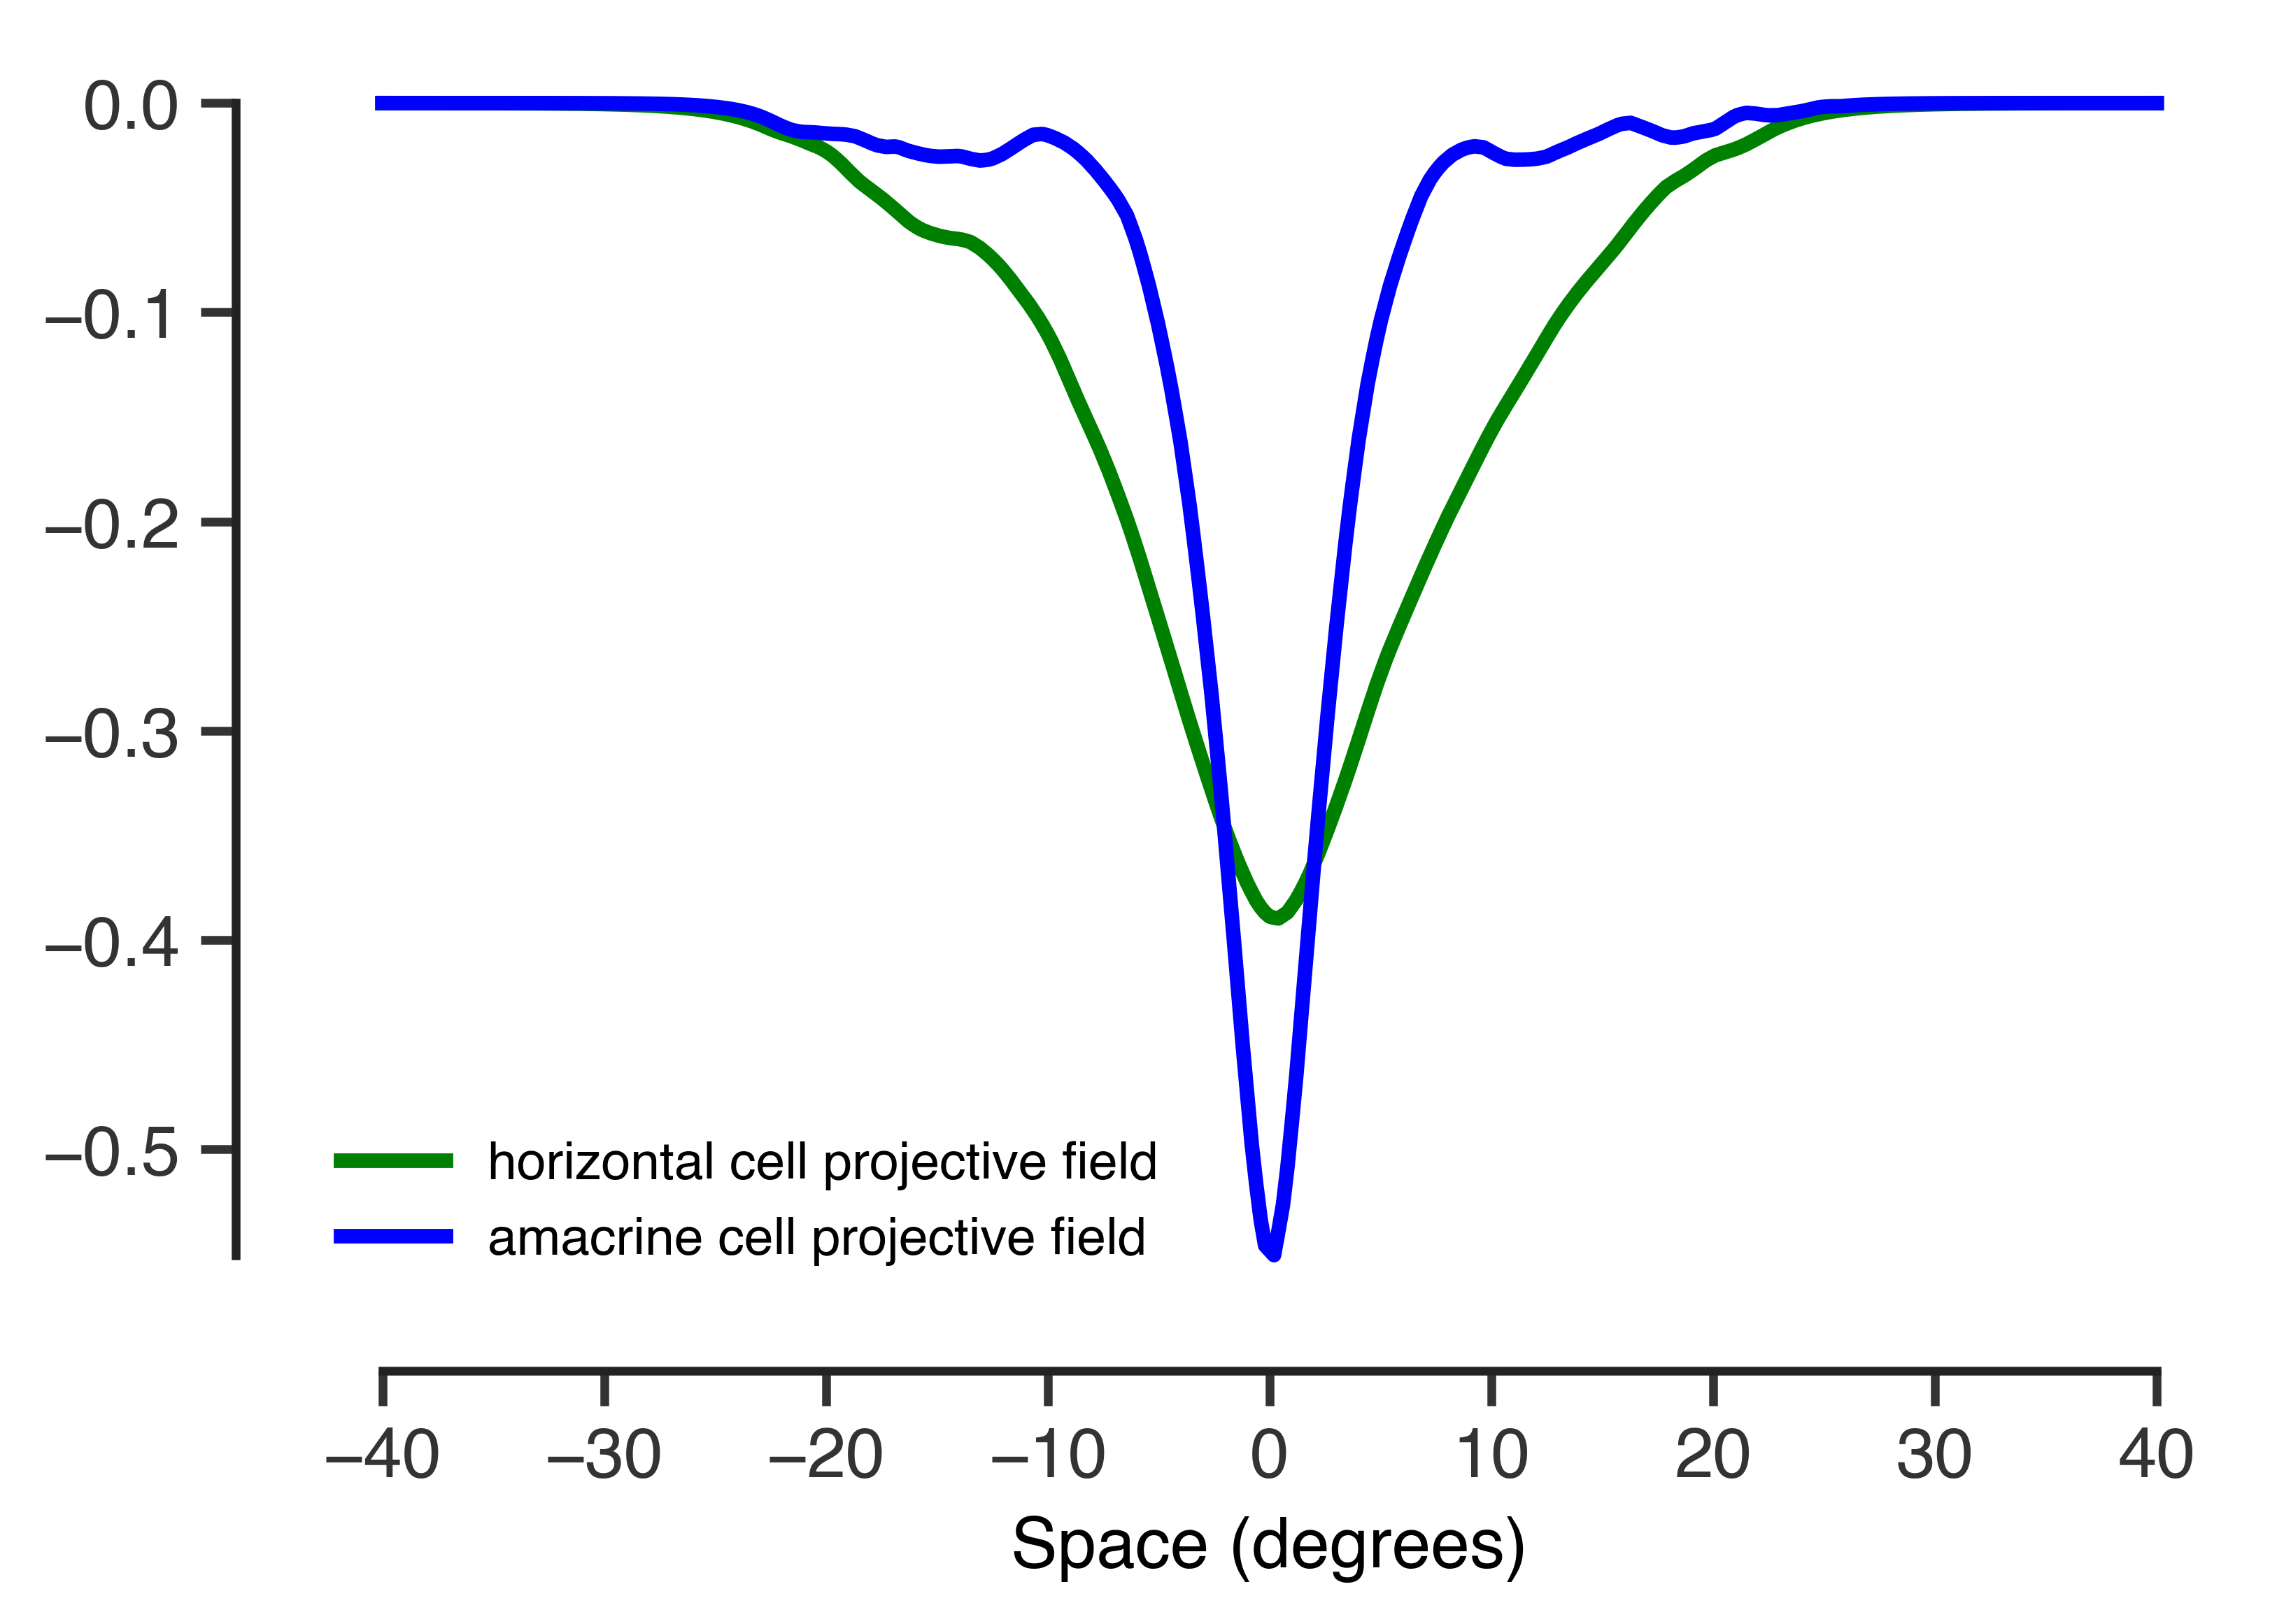

In [12]:
plt.plot(space, horz_pf, 'g', label='horizontal cell projective field')
plt.plot(space, ama_pf, 'b', label='amacrine cell projective field')
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Signal

In [13]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [14]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


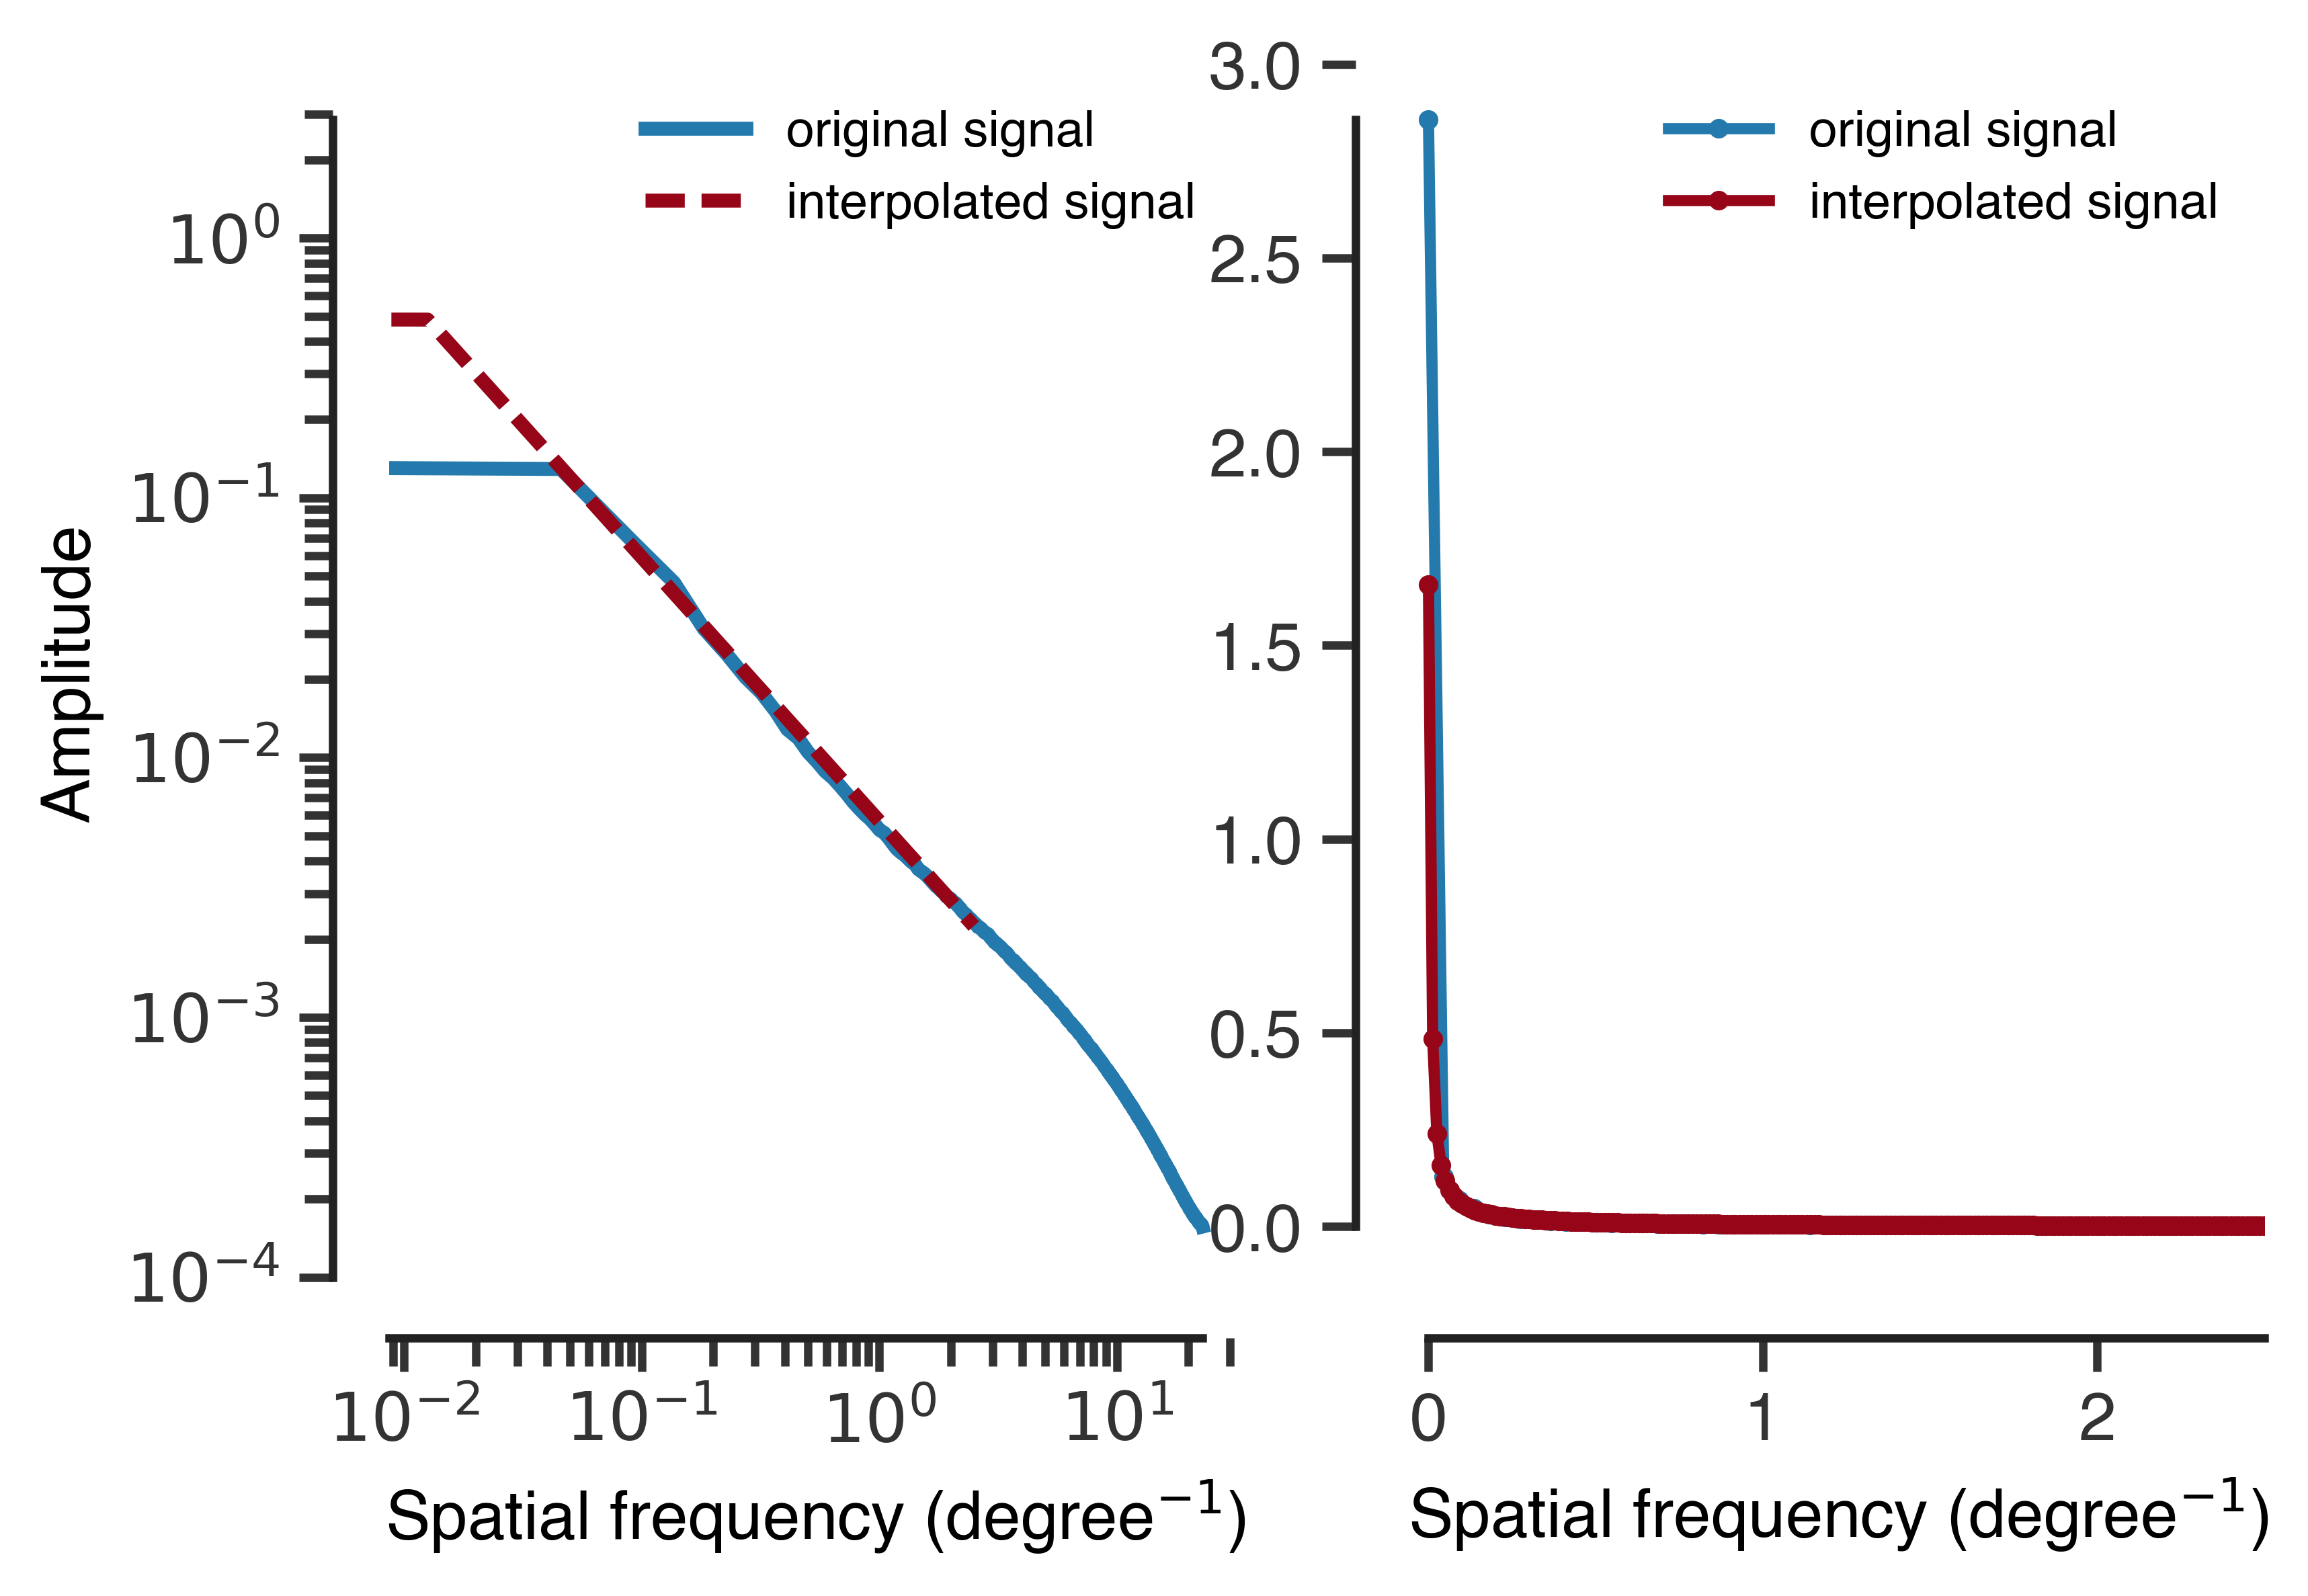

In [15]:
plt.subplot(121)
plt.plot(signal_freqs, signal_amps, label='original signal')
plt.plot(freqs, signal, '--', label='interpolated signal')
plt.legend(frameon=False, fontsize=9)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())
plt.xlabel('Spatial frequency (degree$^{-1}$)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(signal_freqs, signal_amps, '.-', markersize=6, linewidth=2, label='original signal')
plt.plot(freqs, signal, '.-', markersize=6, linewidth=2, label='interpolated signal')
adjust_spines(plt.gca())
plt.xlim(-.05, 2.5)
# plt.ylim(-.05, 1.8)
plt.xlabel('Spatial frequency (degree$^{-1}$)')
# plt.ylabel('Amplitude')
plt.legend(frameon=False, fontsize=9)

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [16]:
input_noise = 0.098762200628786892
output_noise = 0.22313963794641878

1.92576871465


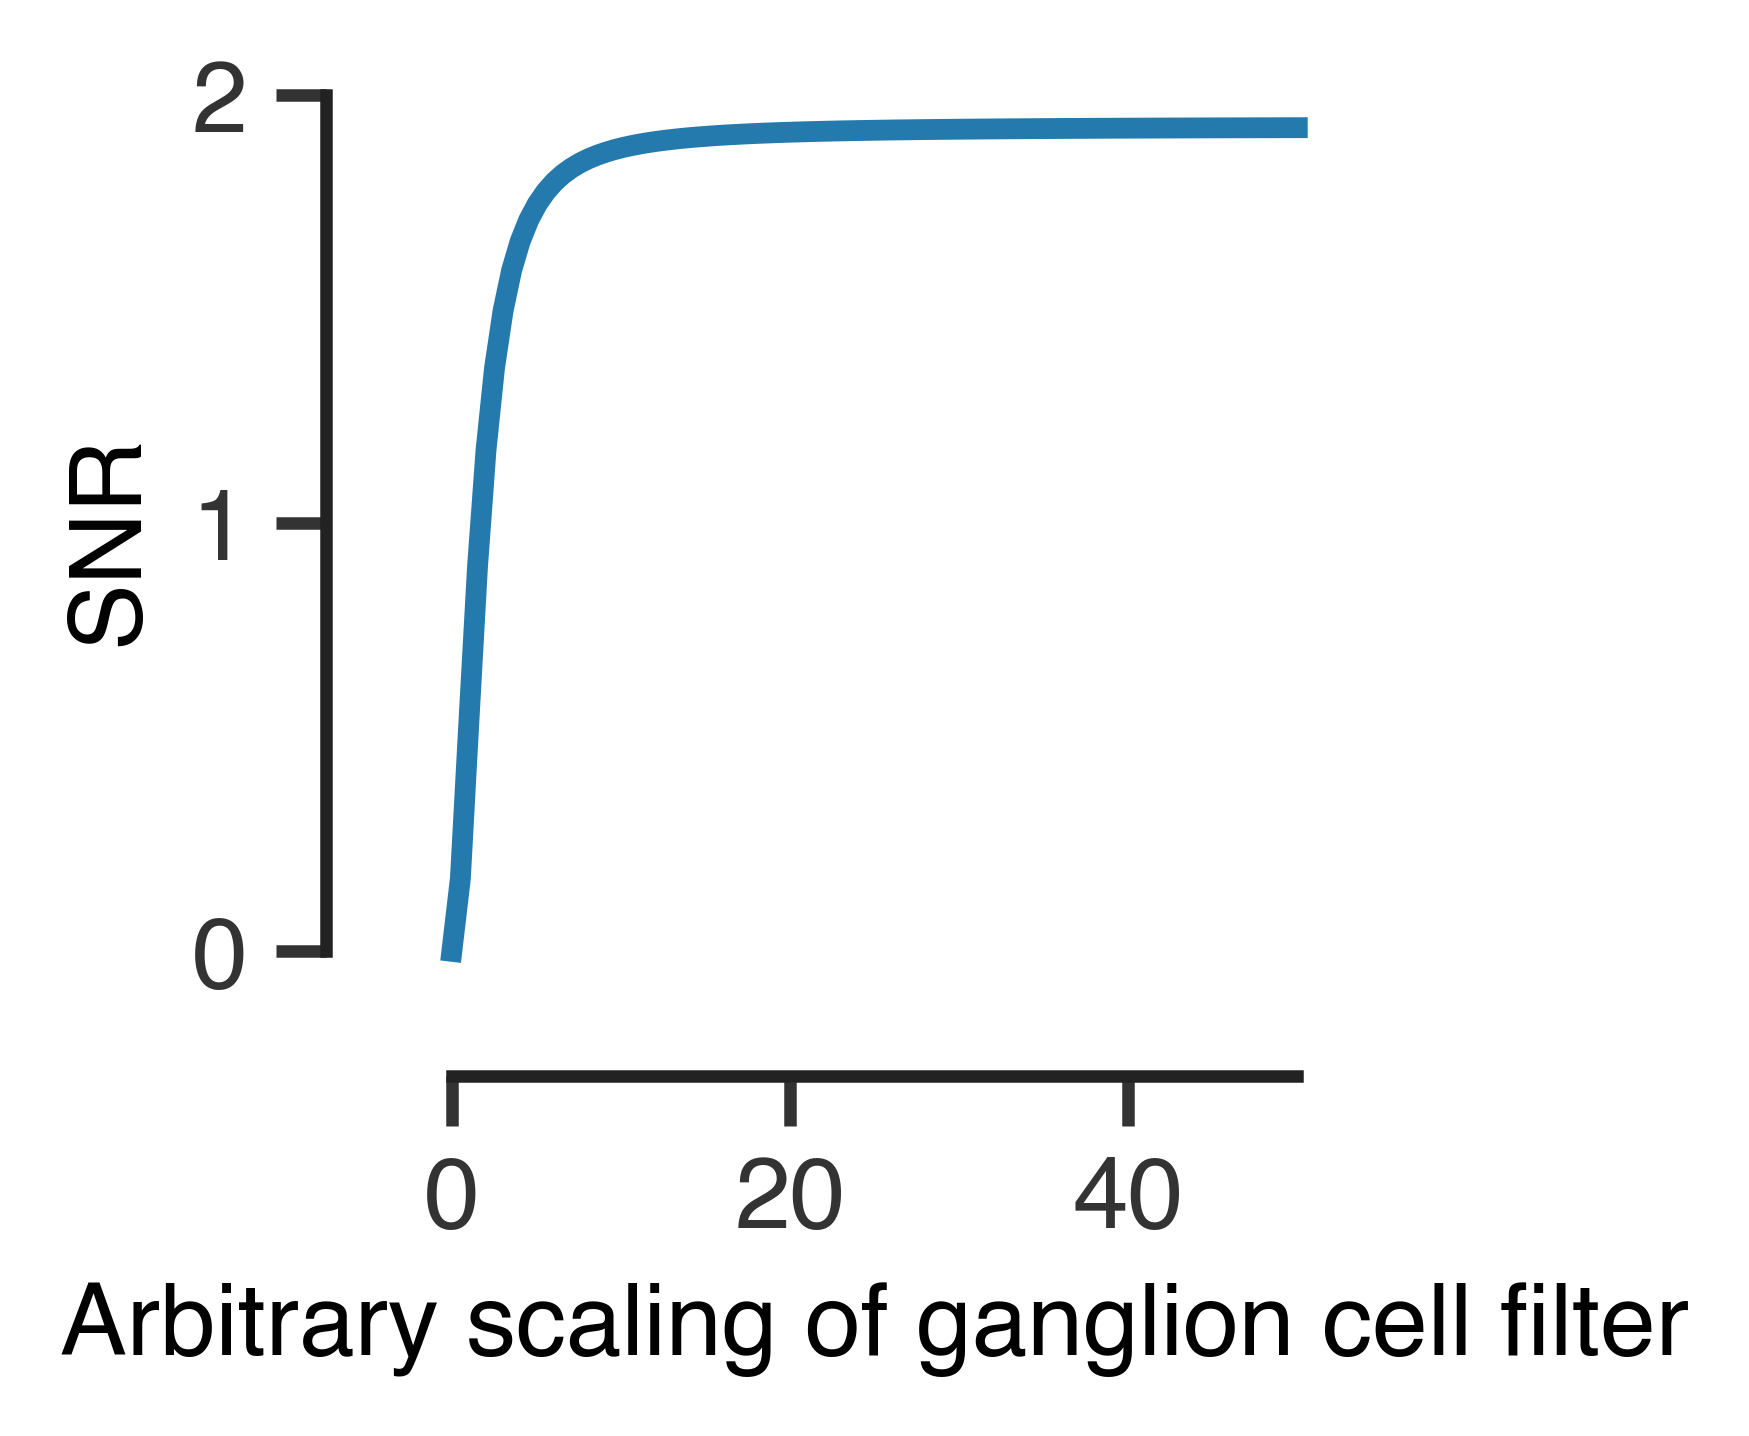

In [17]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [18]:
print(get_snr(0.1, 0.35, signal, 2*average_ganglion_fft, mode='variance'))

0.727739726792


### Ideal filter

In [19]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.67382449273e-08.


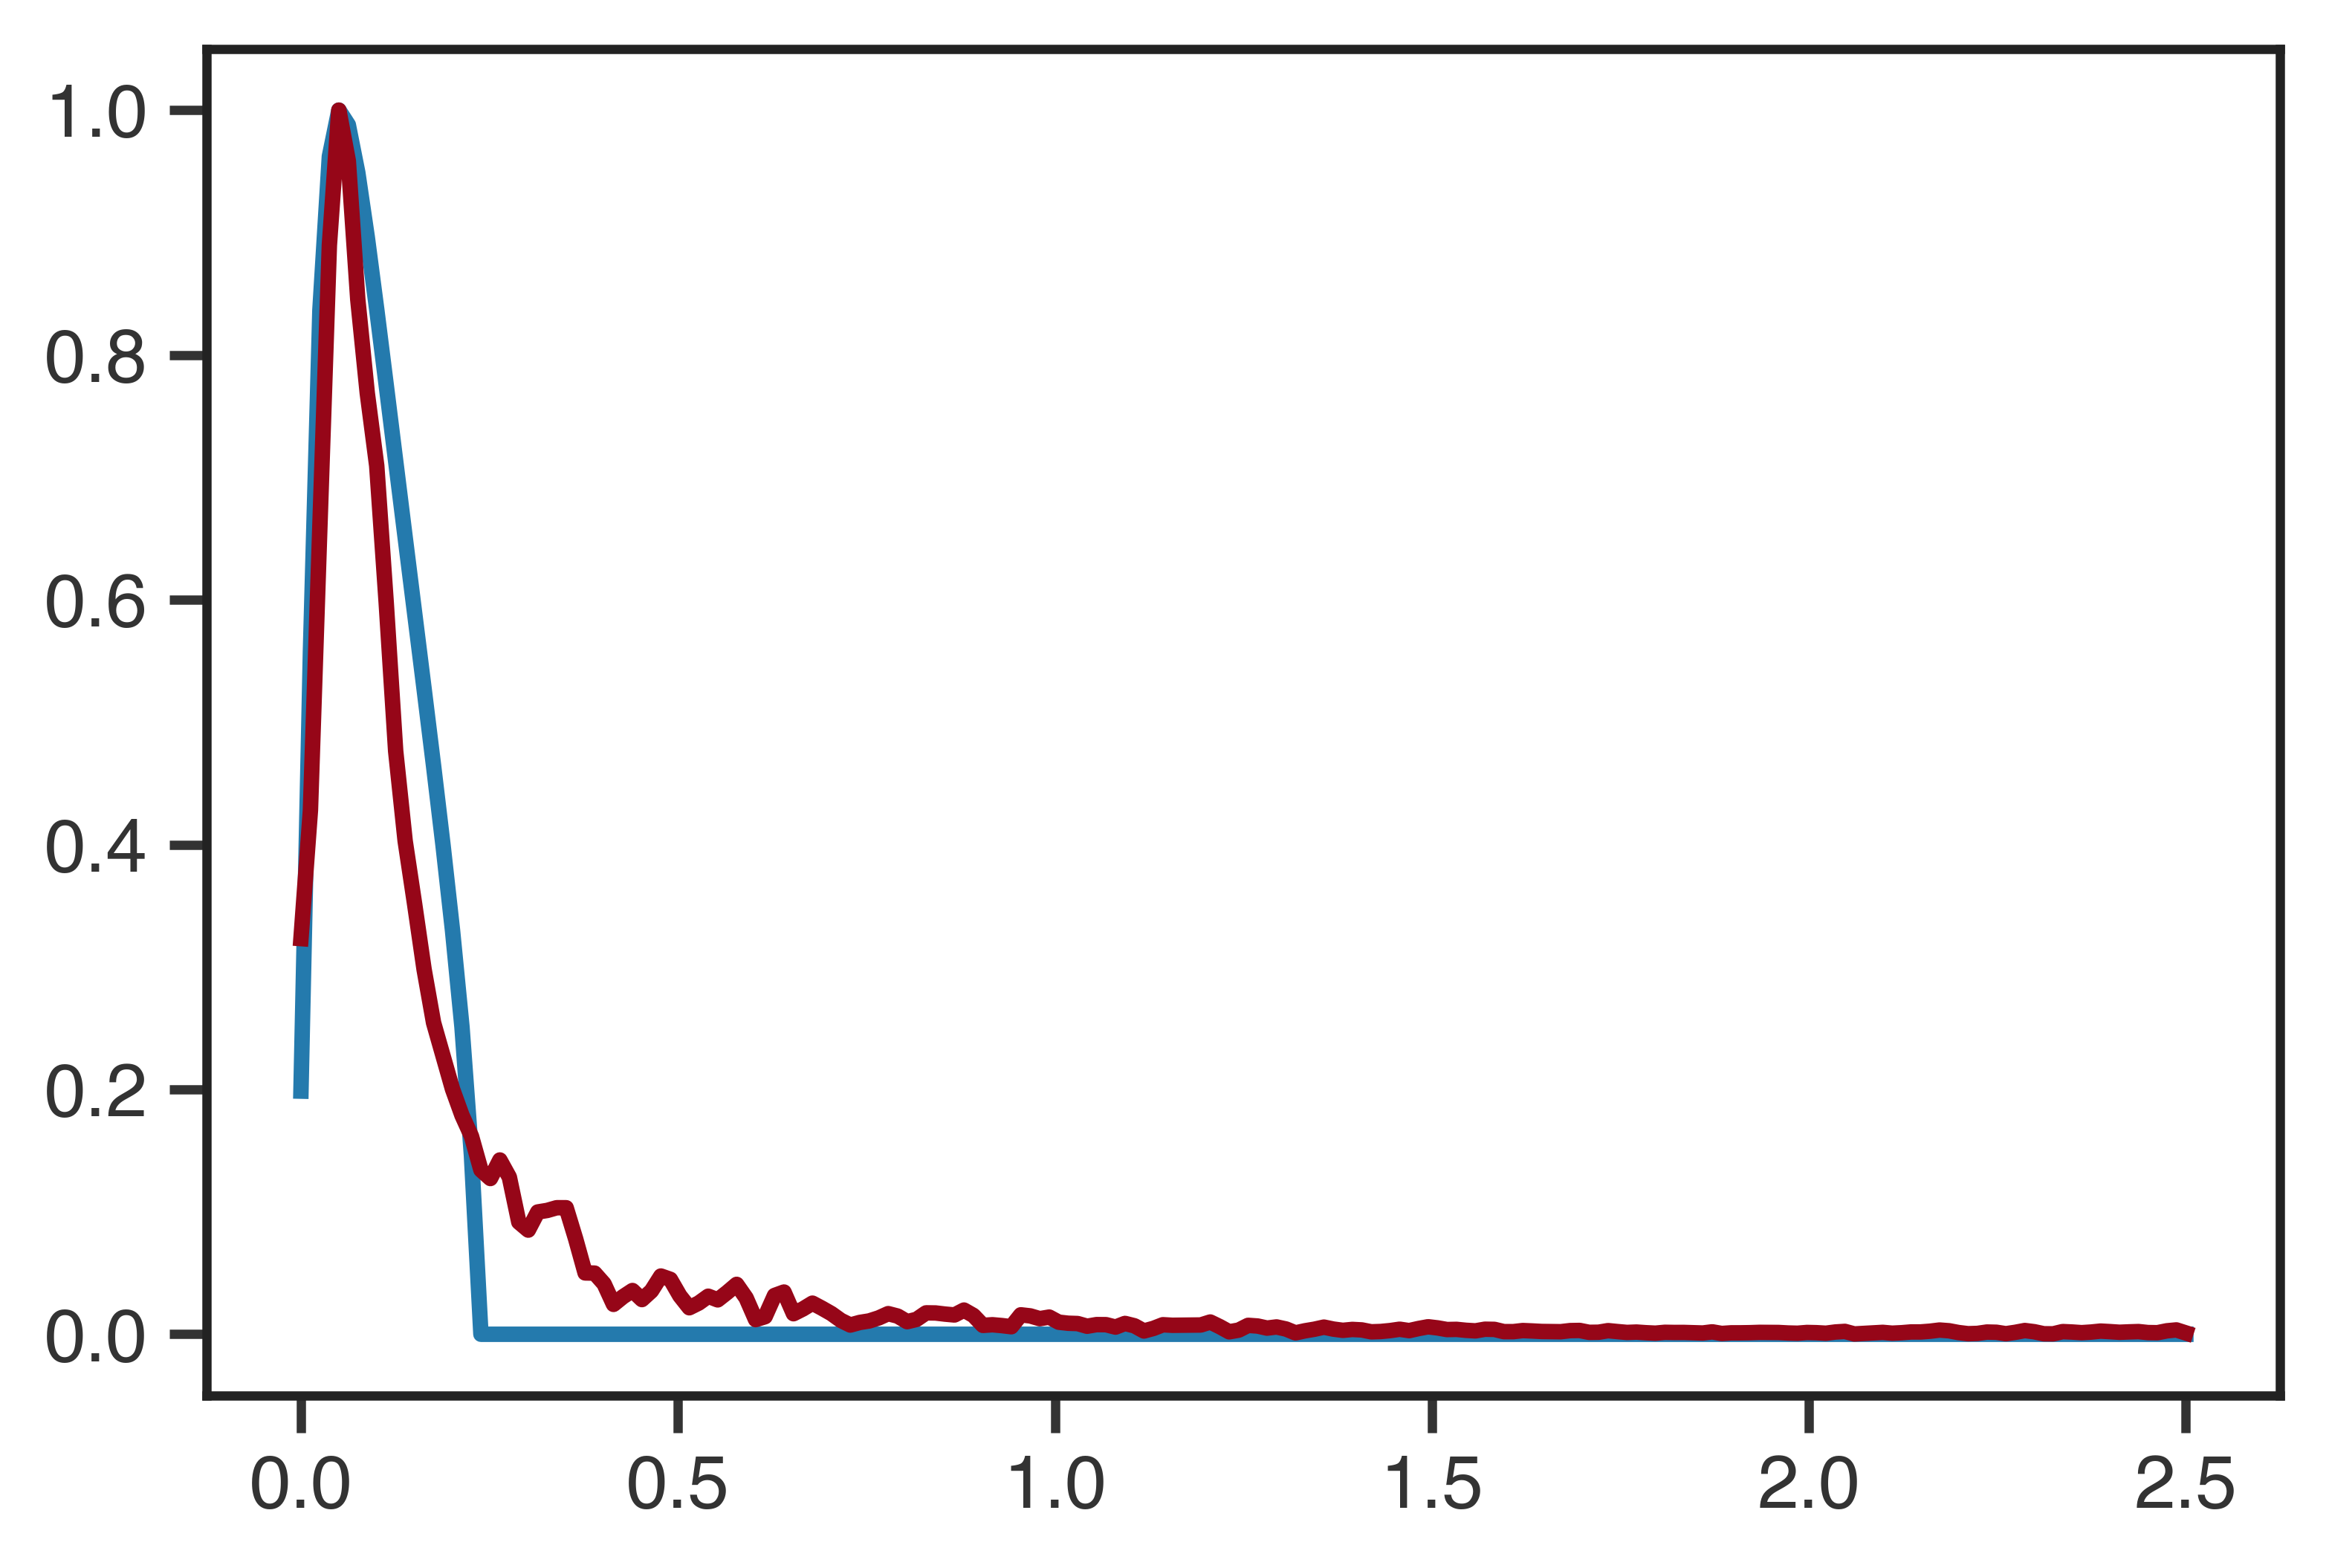

In [20]:
plt.plot(freqs, ideal_filter/np.max(ideal_filter))
plt.plot(freqs, average_ganglion_fft/np.max(average_ganglion_fft))

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [21]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

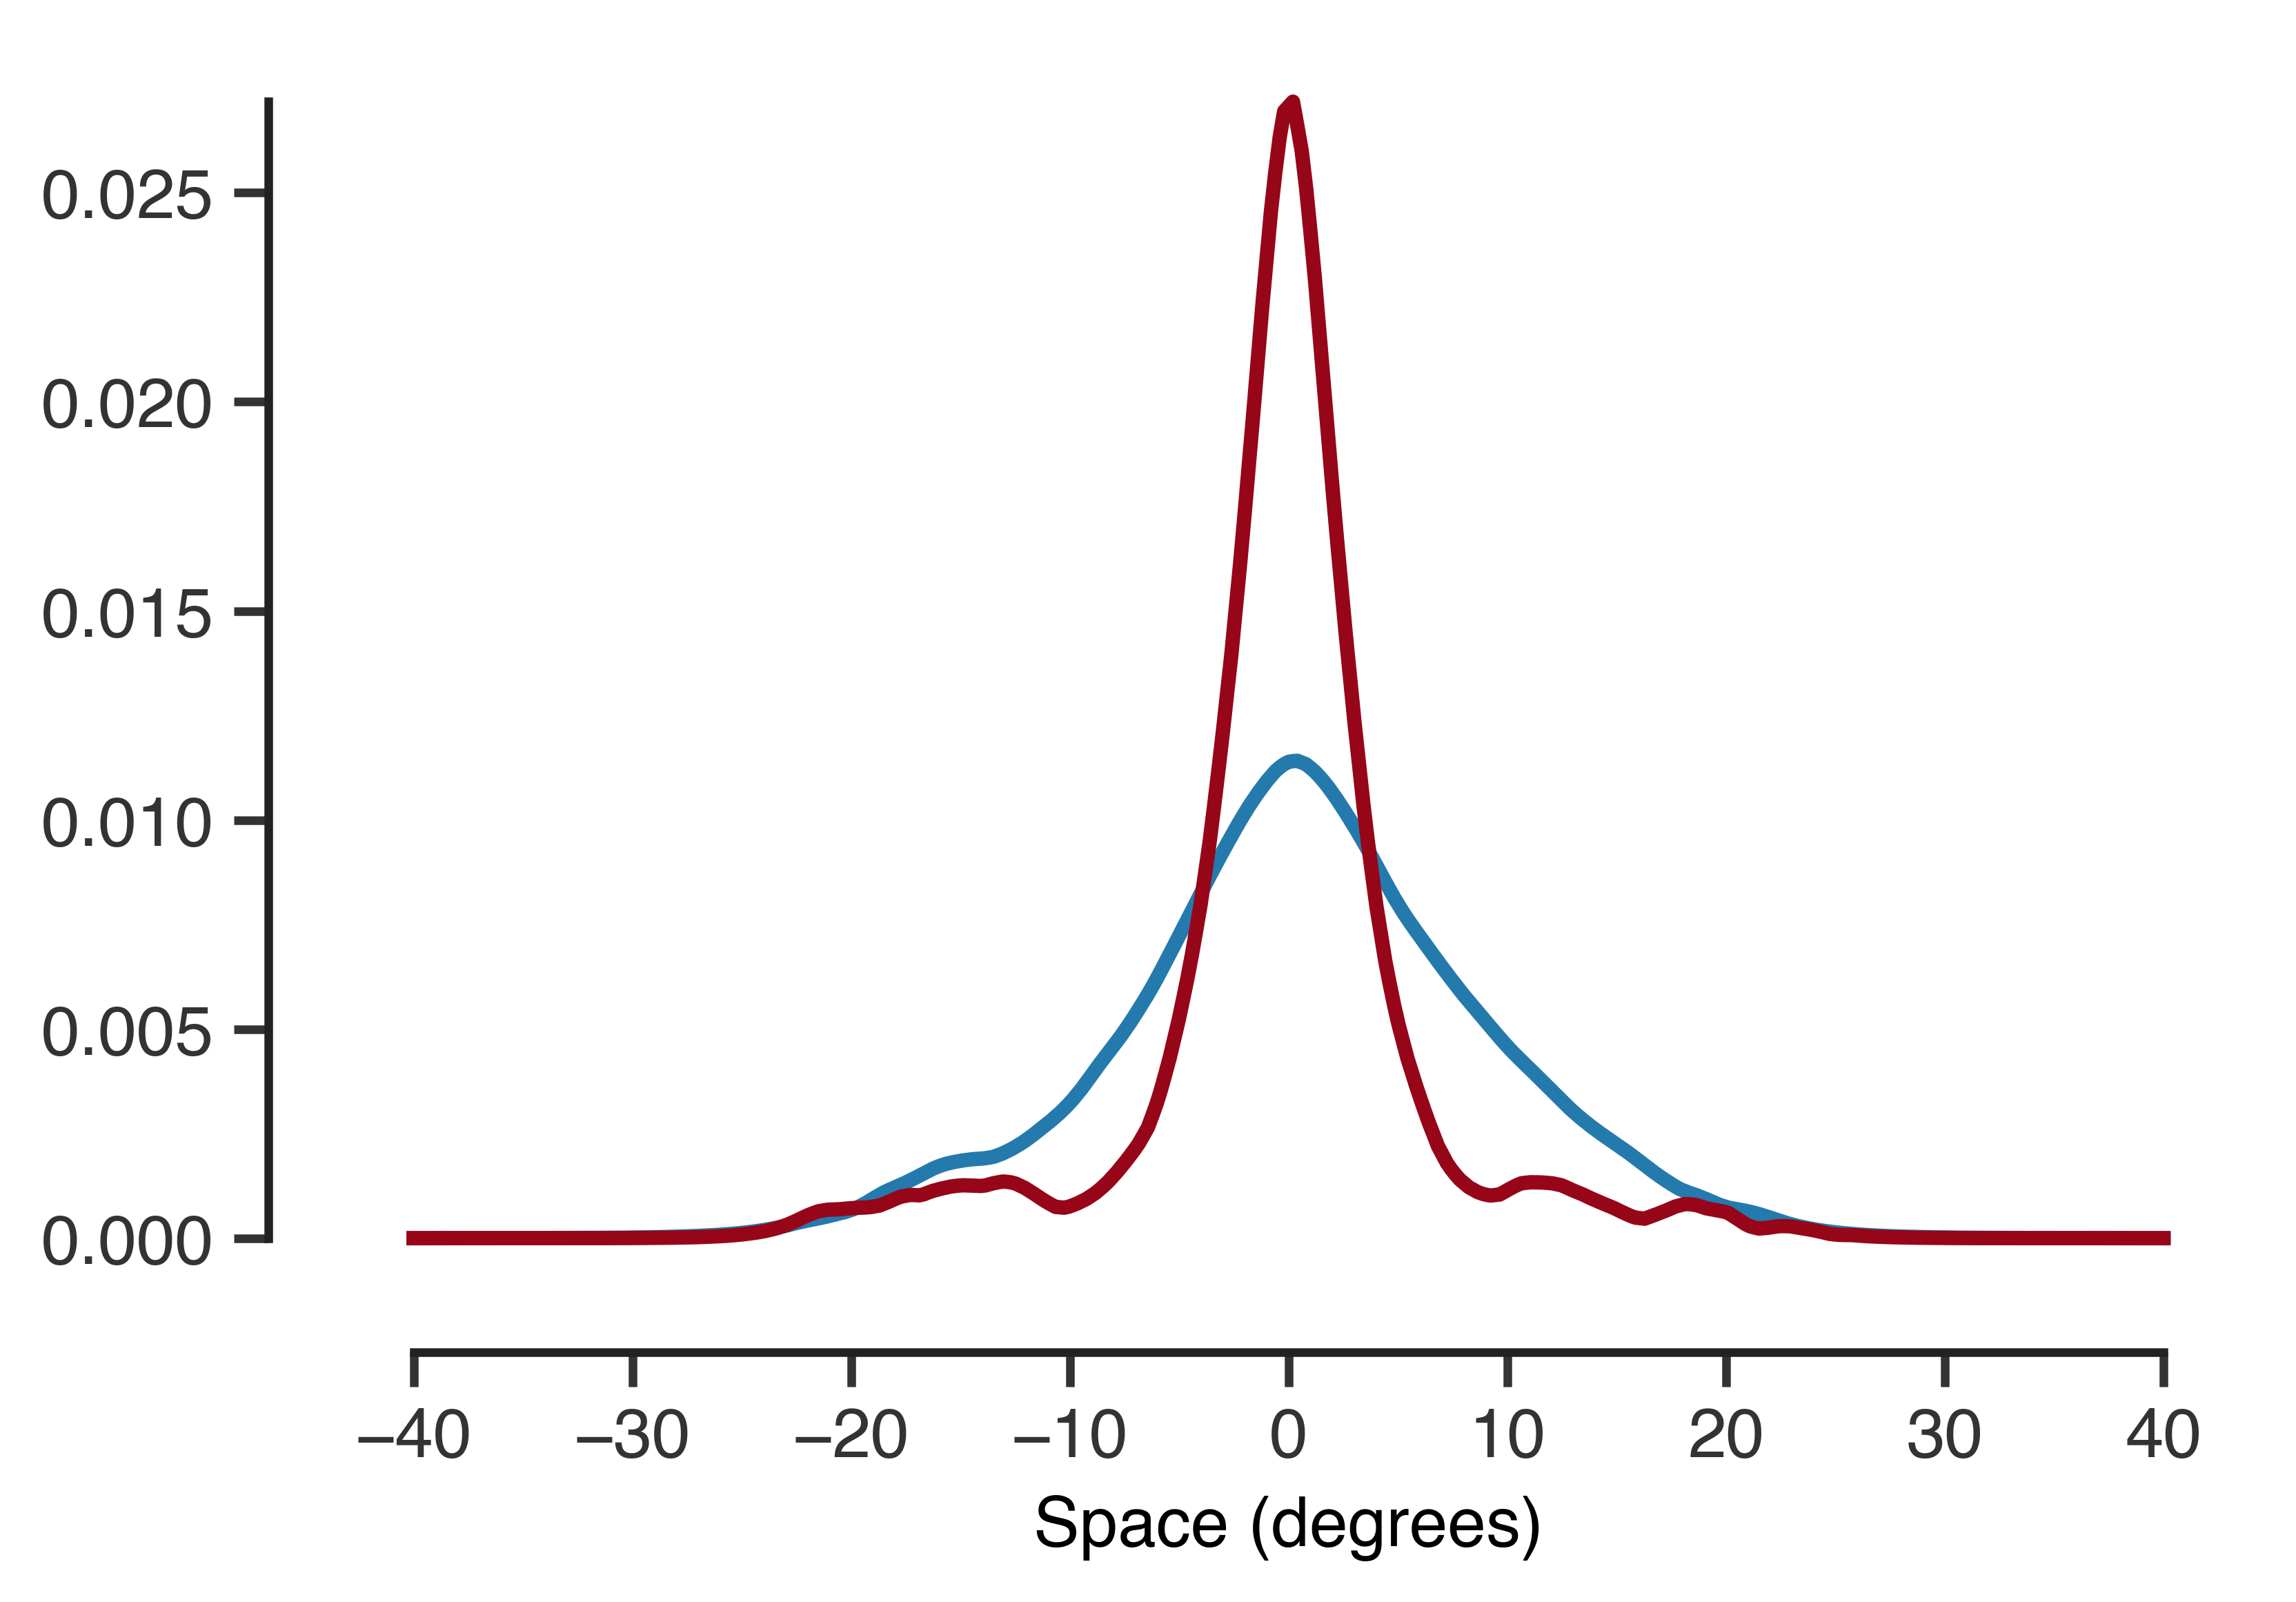

In [22]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

Load David's 1721 ganglion cells

In [23]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [24]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

# Determine input, output noise

In [42]:
np.sum(signal**2)

3.1268268514289623

In [43]:
np.sum(0.1**2 * np.ones_like(signal))

2.0000000000000009

In [44]:
6.4113917119258064/np.sum(signal**2)

2.0504466721576846

In [45]:
1.6028479289772422/np.sum(signal**2)

0.51261166835788796

SNR = mean(signal$^2$) / mean(noise$^2$)  
sqrt(mean(signal$^2$)/SNR) = noise

In [46]:
np.sqrt(np.mean(signal**2)/6.4113917119258064)

0.049381100329732773

### Using old SNR from a single bipolar cell,

In [47]:
np.sqrt(np.mean(signal**2)/1.6028479289772422)

0.098762200628786892

# With Steve's updated input SNR measurement from multiple bipolar cells,  
new estimate is  
Bipolar cell SNR 7.1 ± 5

This means that the input noise var should be

In [48]:
np.sqrt(np.mean(signal**2)/7.1)

0.046925374164122881

In [53]:
input_noise = np.sqrt(np.mean(signal**2)/7.1)
print(input_noise)

0.0469253741641


In [49]:
target_power = 50.0

In [50]:
def constrain_filt_power(filt_const):
    size = len(average_ganglion_fft)
    output_power = np.sum((signal*filt_const*average_ganglion_fft)**2 
                          + (input_noise*filt_const*average_ganglion_fft)**2
                          + output_noise**2)

    return (target_power - output_power)**2

In [51]:
filt_const_opt = scipy.optimize.minimize(constrain_filt_power, 0.1)

In [52]:
filt_const_opt

      fun: 2.5011277458502576e-13
 hess_inv: array([[ 0.00011097]])
      jac: array([ -6.10488656e-11])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([ 1.19306886])

In [55]:
get_snr(0.1, 0.35, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

0.34508877777253649

In [56]:
get_snr(input_noise, 0.35, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

0.40279332836945259

In [57]:
def find_output_noise(x):
    this_snr = get_snr(0.1, x, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

output_noise_opt = scipy.optimize.minimize_scalar(find_output_noise)

In [58]:
output_noise_opt

     fun: 6.7509754469403706e-19
    nfev: 17
     nit: 16
 success: True
       x: 0.40602871137578705

In [59]:
def find_output_noise(x):
    this_snr = get_snr(input_noise, x, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

output_noise_opt = scipy.optimize.minimize_scalar(find_output_noise)

In [60]:
output_noise_opt

     fun: 2.2136310829812129e-20
    nfev: 17
     nit: 16
 success: True
       x: 0.43169259559119894

### Another way of going about this would be to fix the output noise, and vary the filter constant

In [61]:
def find_filt_const(filt_const):
    this_snr = get_snr(0.098762200628786892, 0.35, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

In [62]:
filt_const_opt

     fun: 2.9997285385839205e-19
    nfev: 12
     nit: 11
 success: True
       x: 1.0263257082694519

In [63]:
target_power = np.sum((signal*filt_const_opt.x*average_ganglion_fft)**2 
                          + (0.098762200628786892*filt_const_opt.x*average_ganglion_fft)**2
                          + 0.35**2)

In [64]:
target_power

54.131410989171826

# Now with new measurements

In [65]:
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, 0.35, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

In [66]:
filt_const_opt

     fun: 8.992135004621255e-21
    nfev: 12
     nit: 11
 success: True
       x: 0.96729502935912492

In [67]:
target_power = np.sum((signal*filt_const_opt.x*average_ganglion_fft)**2 
                          + (input_noise*filt_const_opt.x*average_ganglion_fft)**2
                          + 0.35**2)

In [68]:
target_power

48.053365503112332

# I'm curious about how output noise scales with available output power

In [70]:
def find_output_noise(x, filt_const=1.):
    this_snr = get_snr(input_noise, x, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

output_noise_opt = scipy.optimize.minimize_scalar(find_output_noise, args=(1.))

In [71]:
output_noise_opt

     fun: 7.1990158868358307e-22
    nfev: 17
     nit: 16
 success: True
       x: 0.36183376249767796

In [ ]:
target_power = np.sum((signal*filt_const_opt.x*average_ganglion_fft)**2 
                          + (input_noise*filt_const_opt.x*average_ganglion_fft)**2
                          + output_noise_opt**2)

In [78]:
explore_filt_consts = np.linspace(0.1, 50., 1000)
output_powers = []
output_noises = []
fit_error = []
for filt_const in tqdm(explore_filt_consts):
    output_noise_opt = scipy.optimize.minimize_scalar(find_output_noise, args=(filt_const))
    target_power = np.sum((signal*filt_const_opt.x*average_ganglion_fft)**2 
                          + (input_noise*filt_const_opt.x*average_ganglion_fft)**2
                          + output_noise_opt.x**2)
    output_powers.append(target_power)
    fit_error.append(output_noise_opt.fun)
    output_noises.append(output_noise_opt.x)

100%|██████████| 1000/1000 [00:00<00:00, 1146.08it/s]


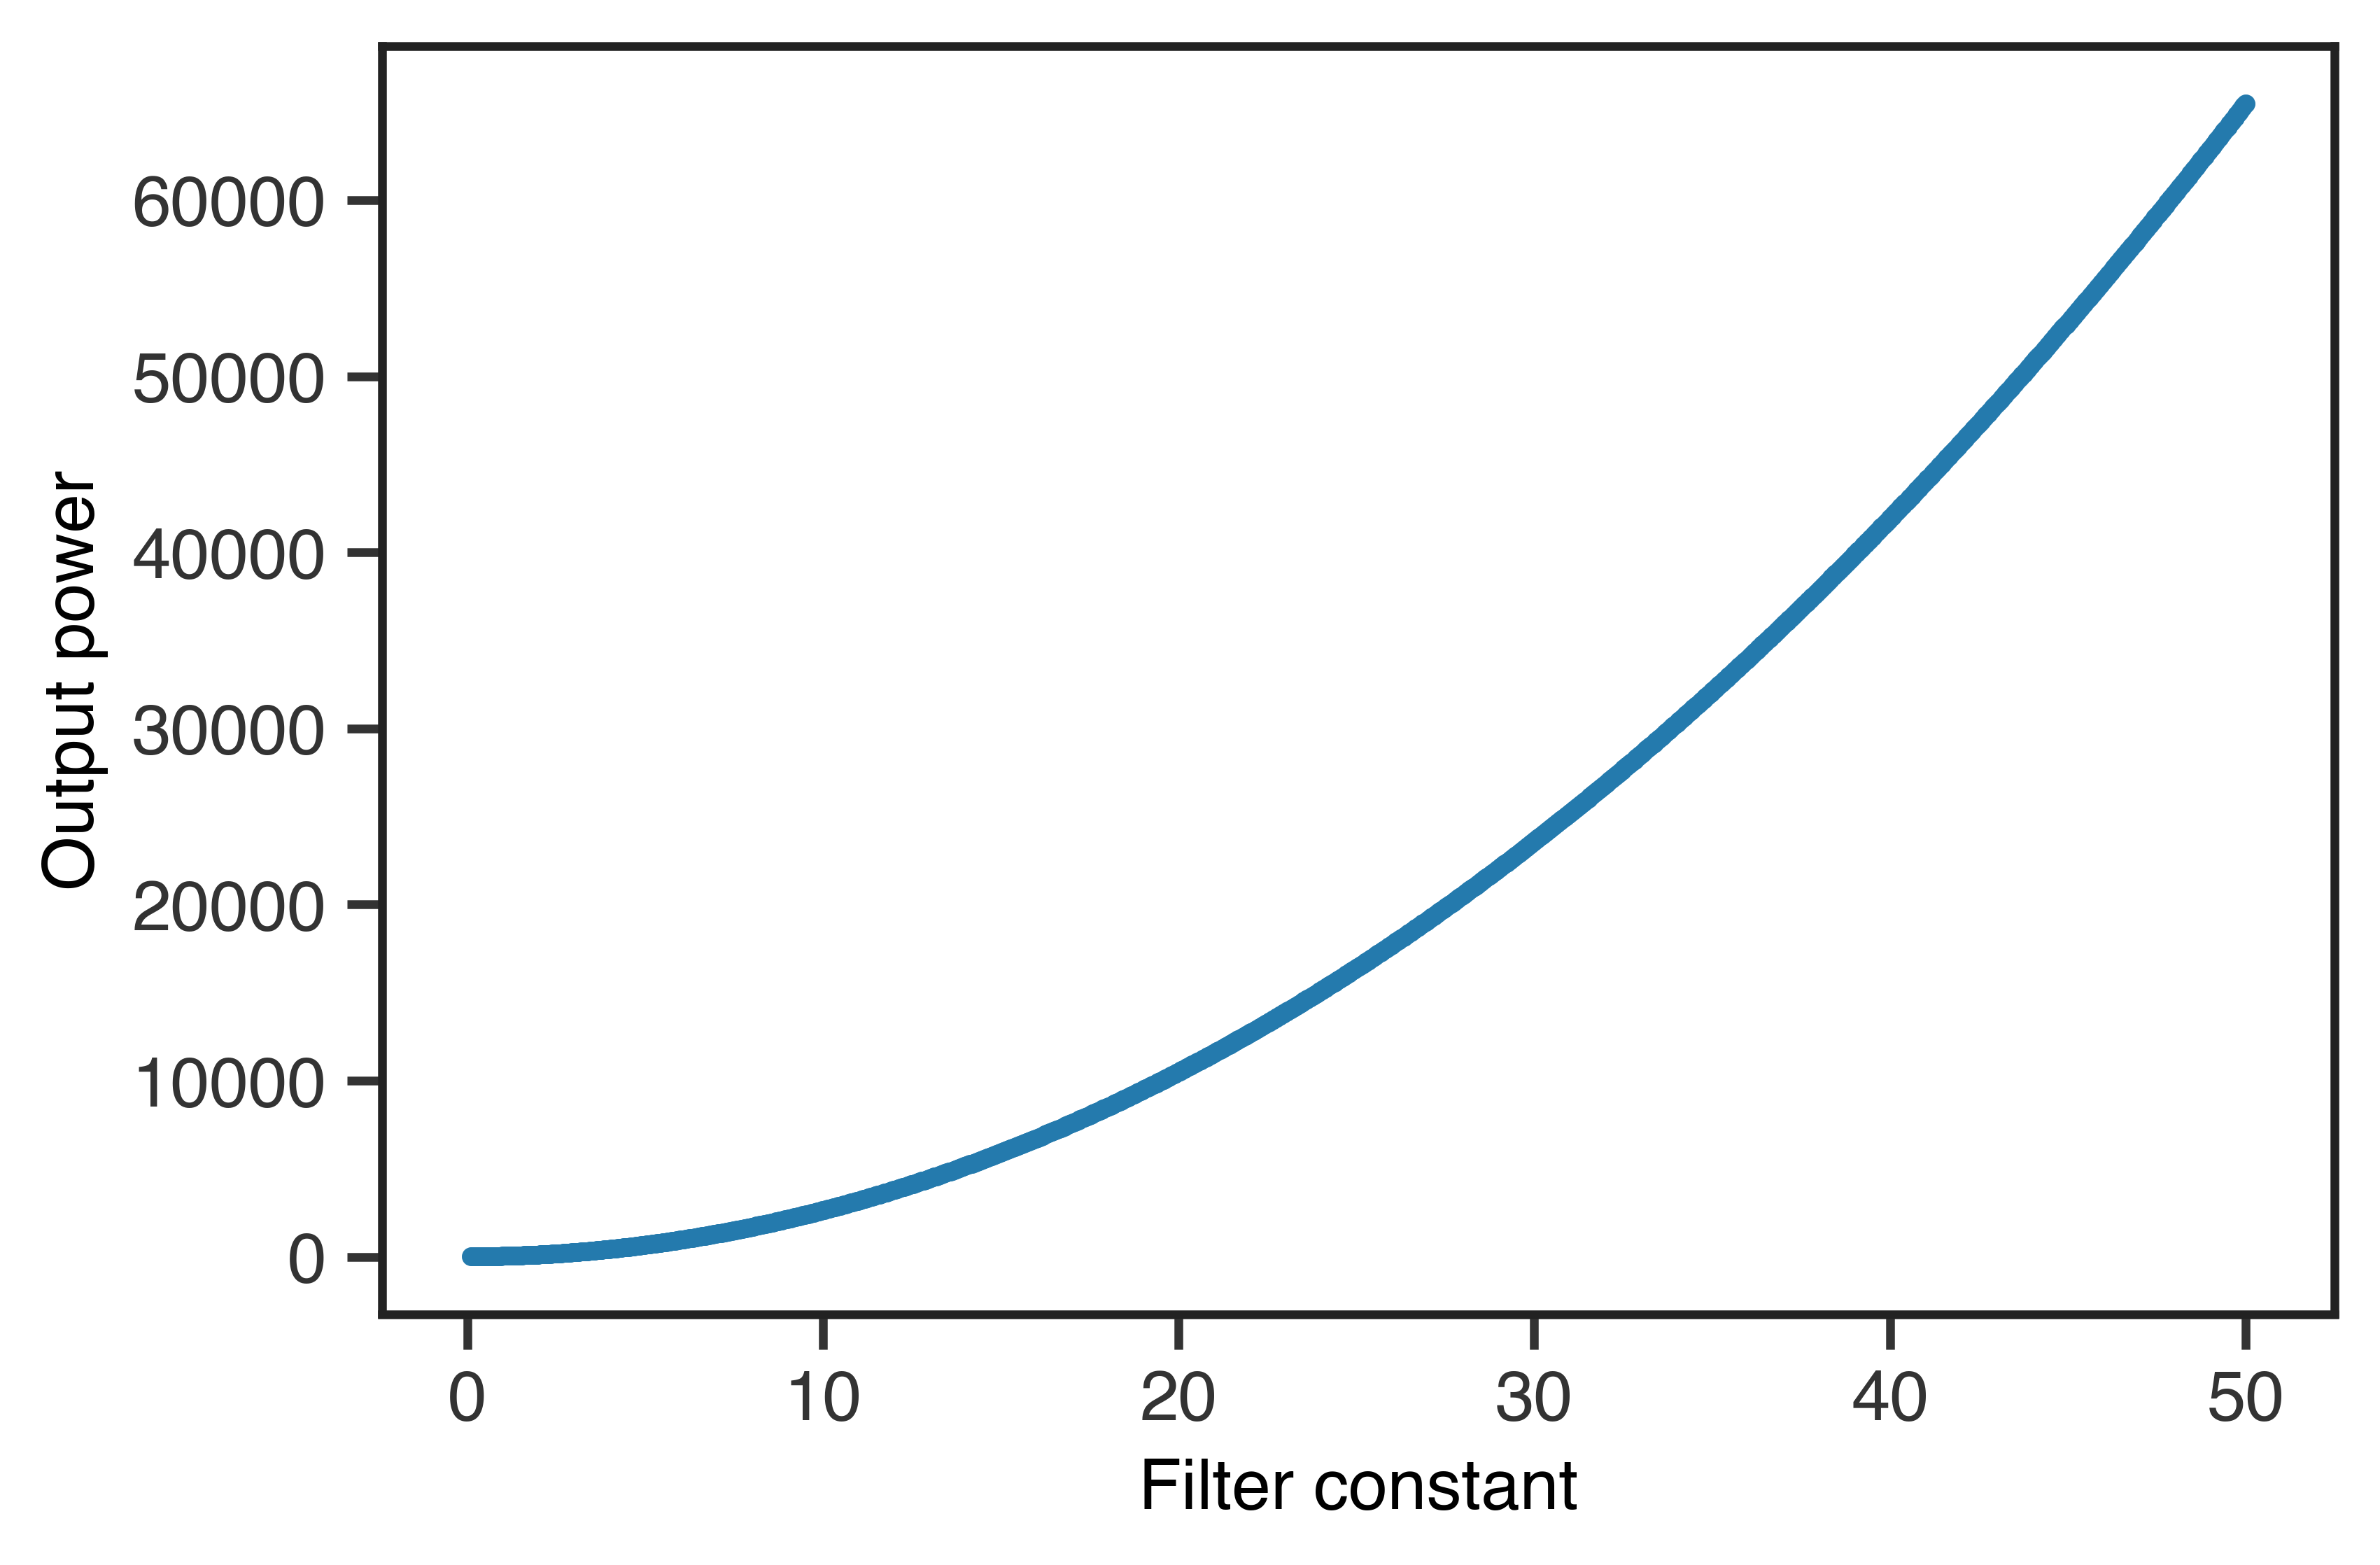

In [83]:
plt.scatter(explore_filt_consts, output_powers, s=5)
plt.ylabel('Output power')
plt.xlabel('Filter constant')

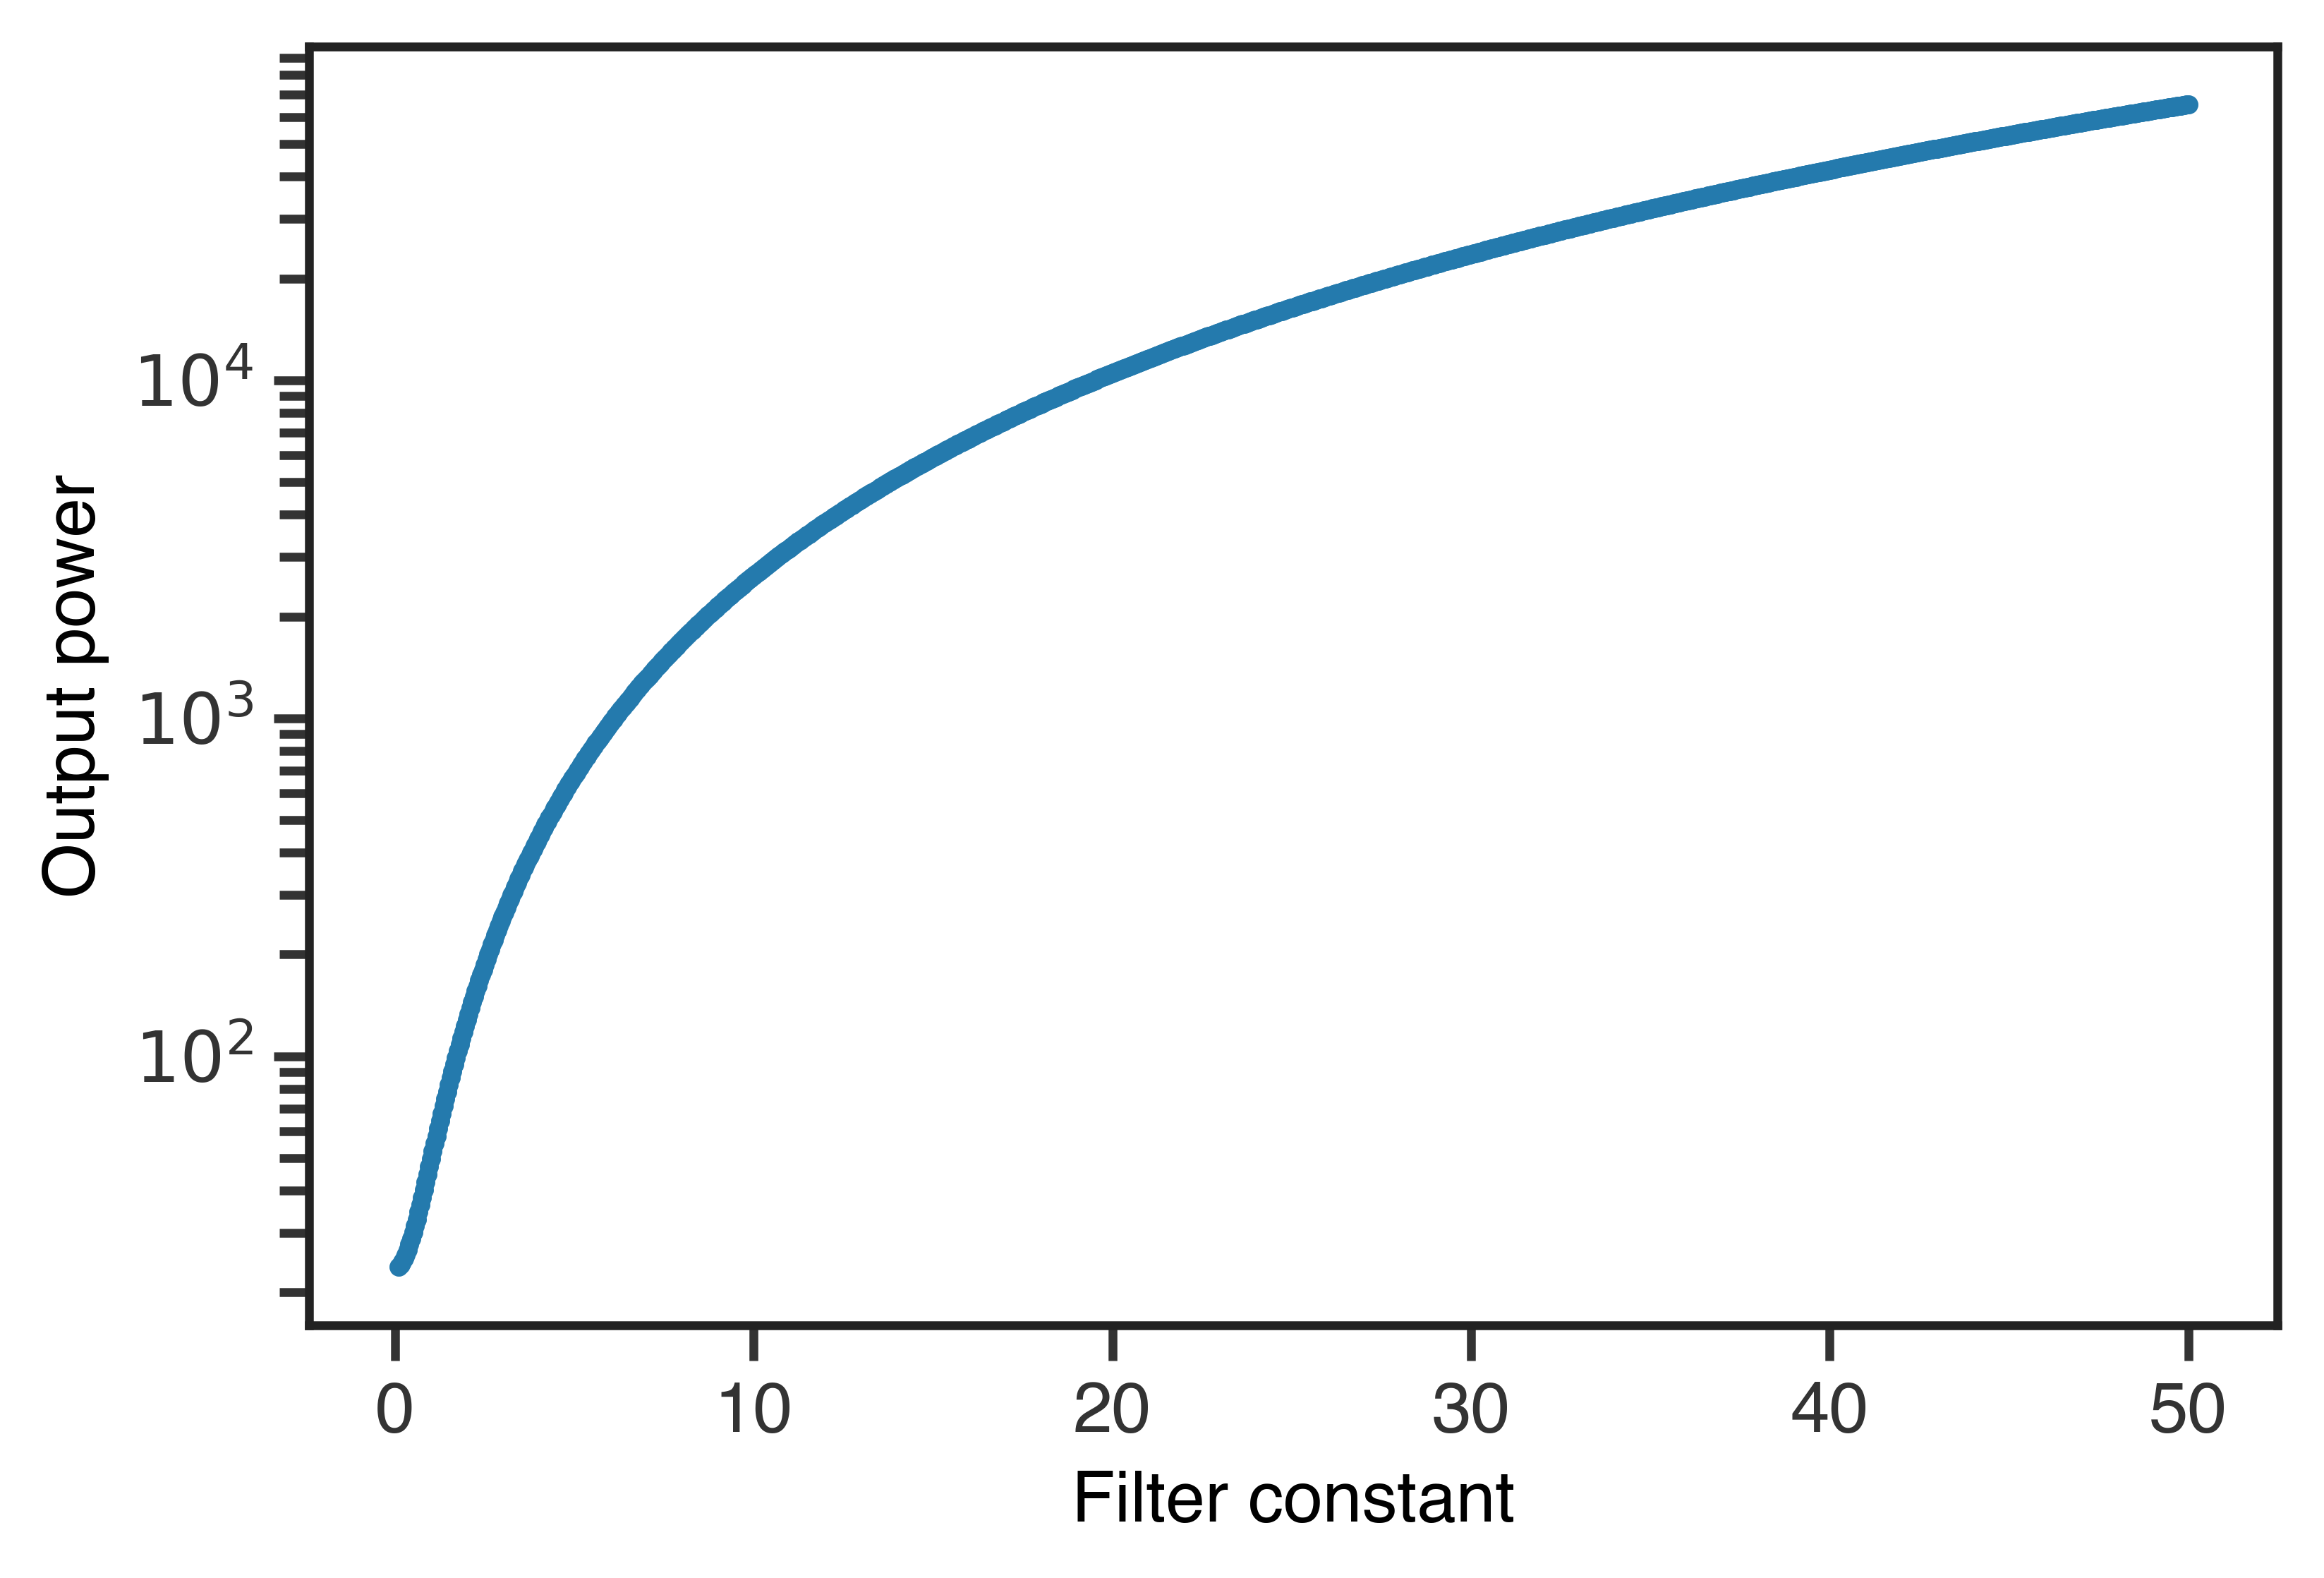

In [82]:
plt.scatter(explore_filt_consts, output_powers, s=5)
plt.ylabel('Output power')
plt.xlabel('Filter constant')
plt.yscale('log')

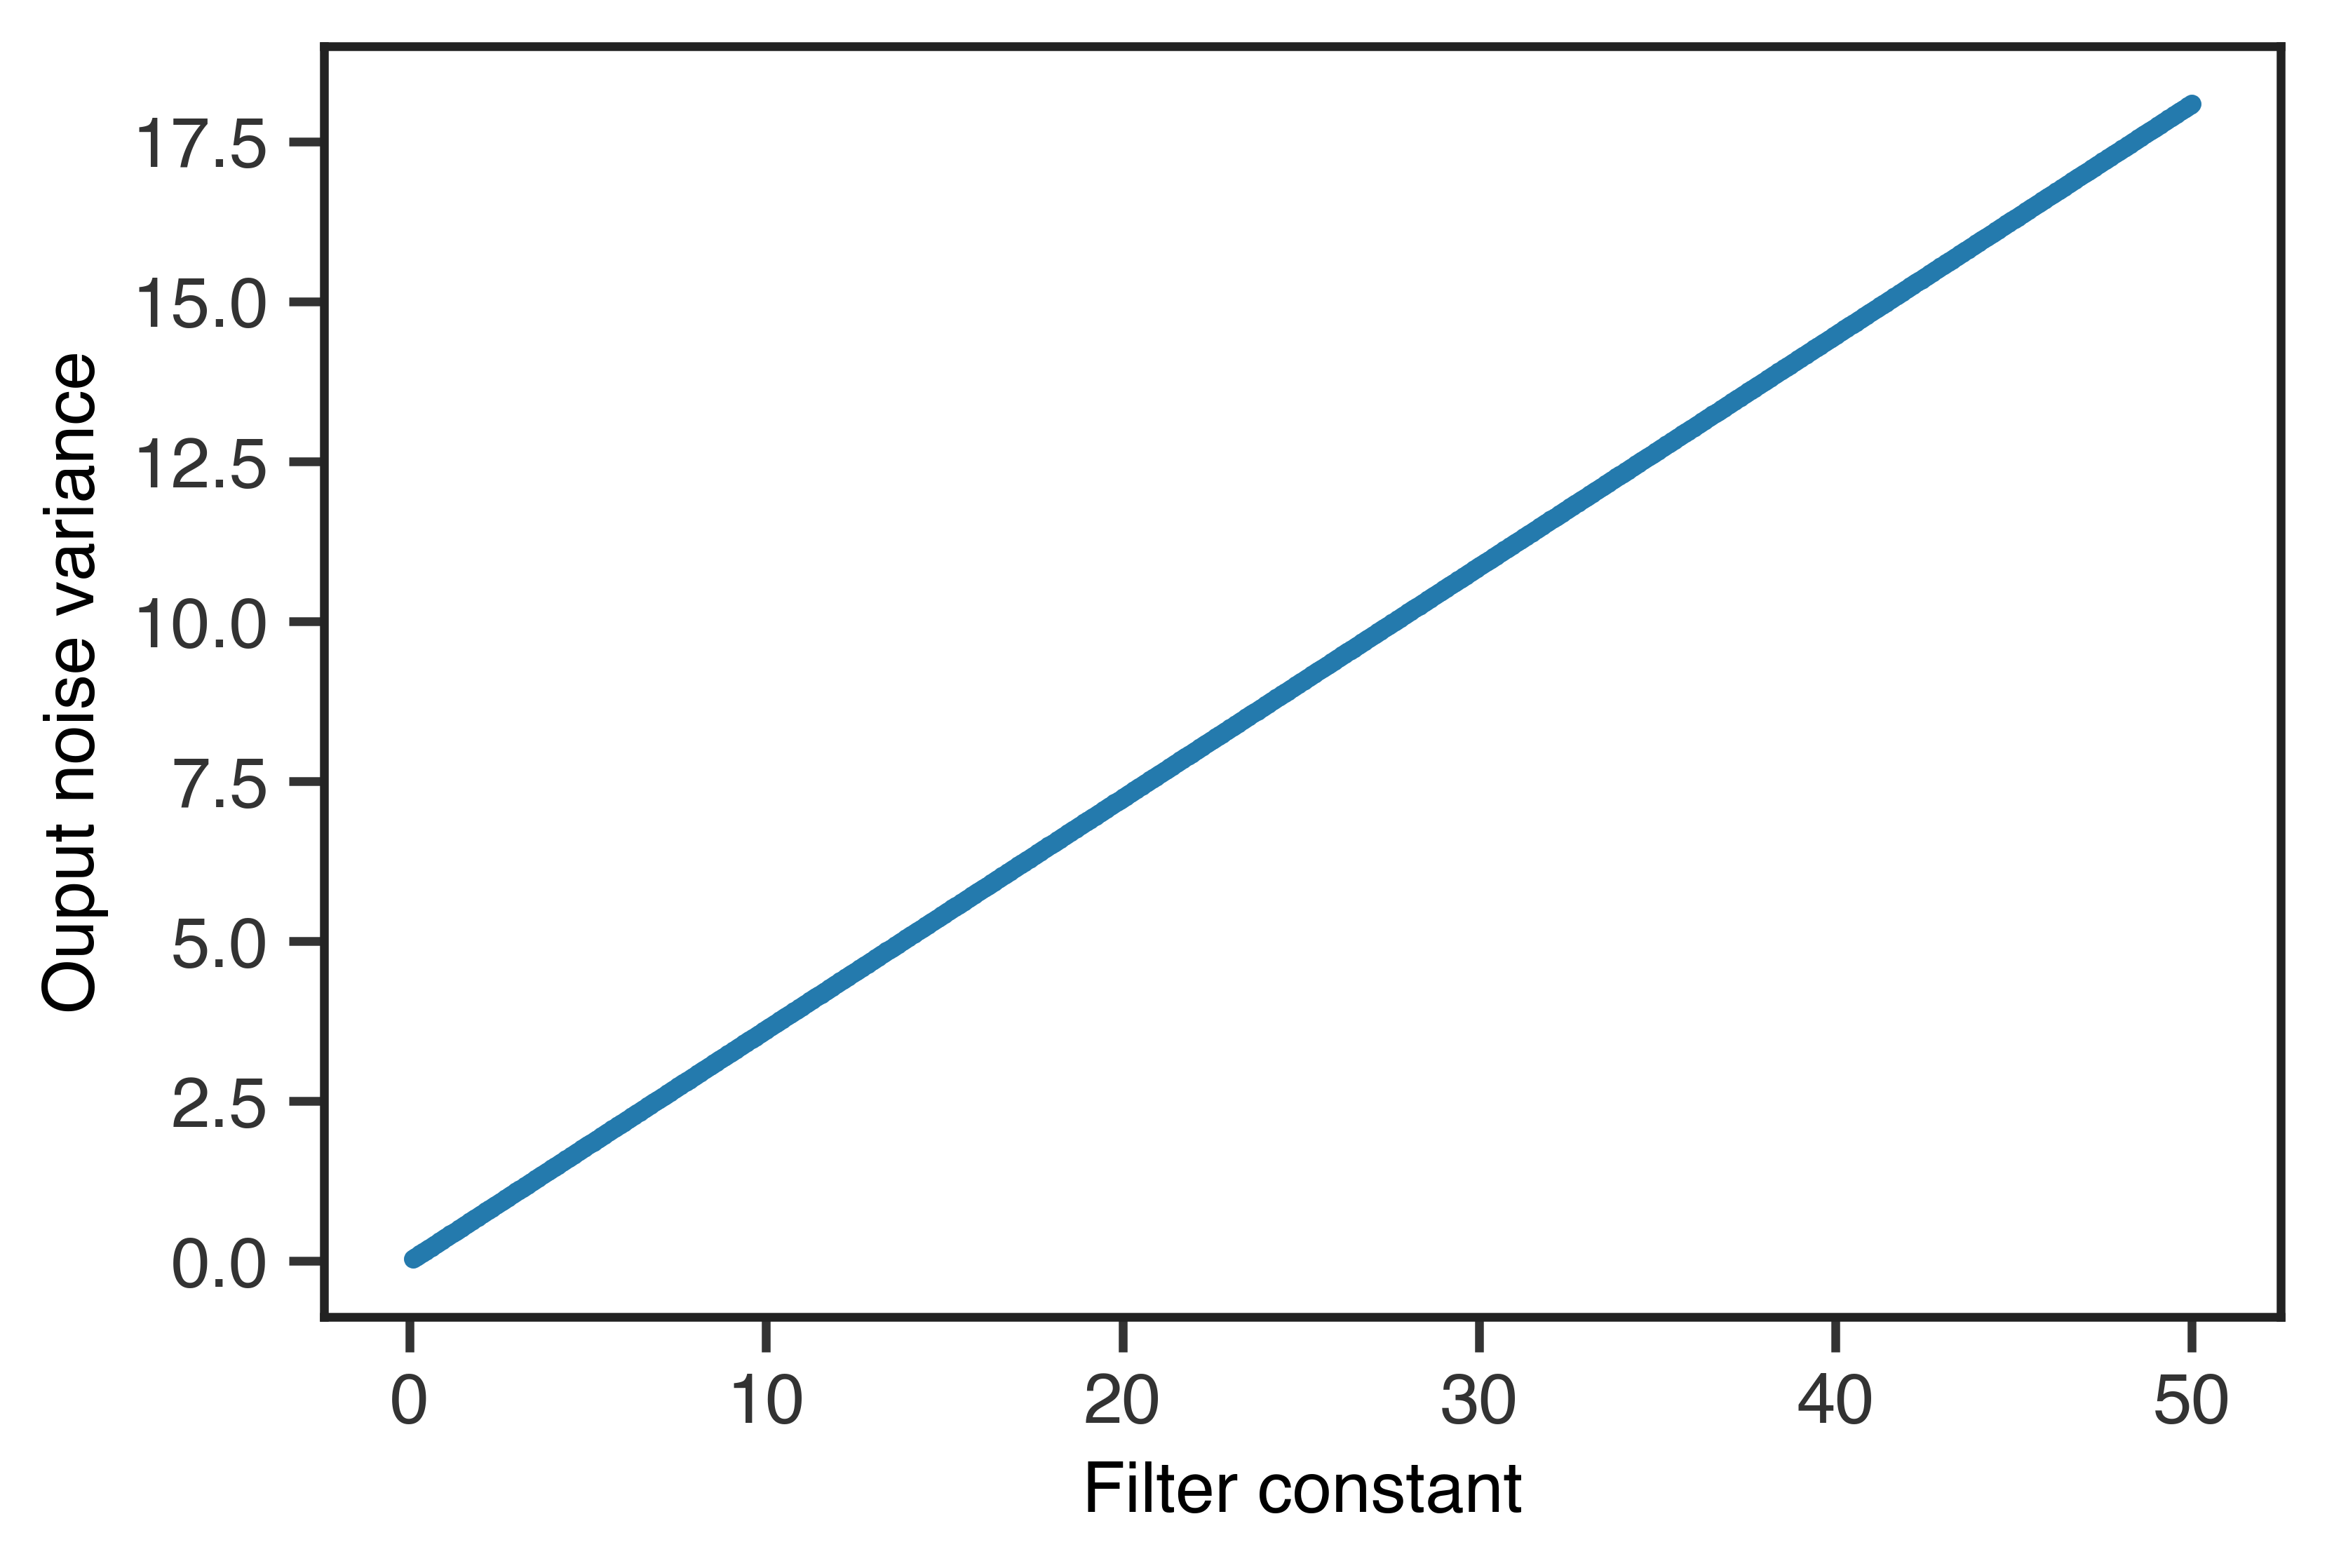

In [84]:
plt.scatter(explore_filt_consts, output_noises, s=5)
plt.ylabel('Ouput noise variance')
plt.xlabel('Filter constant')

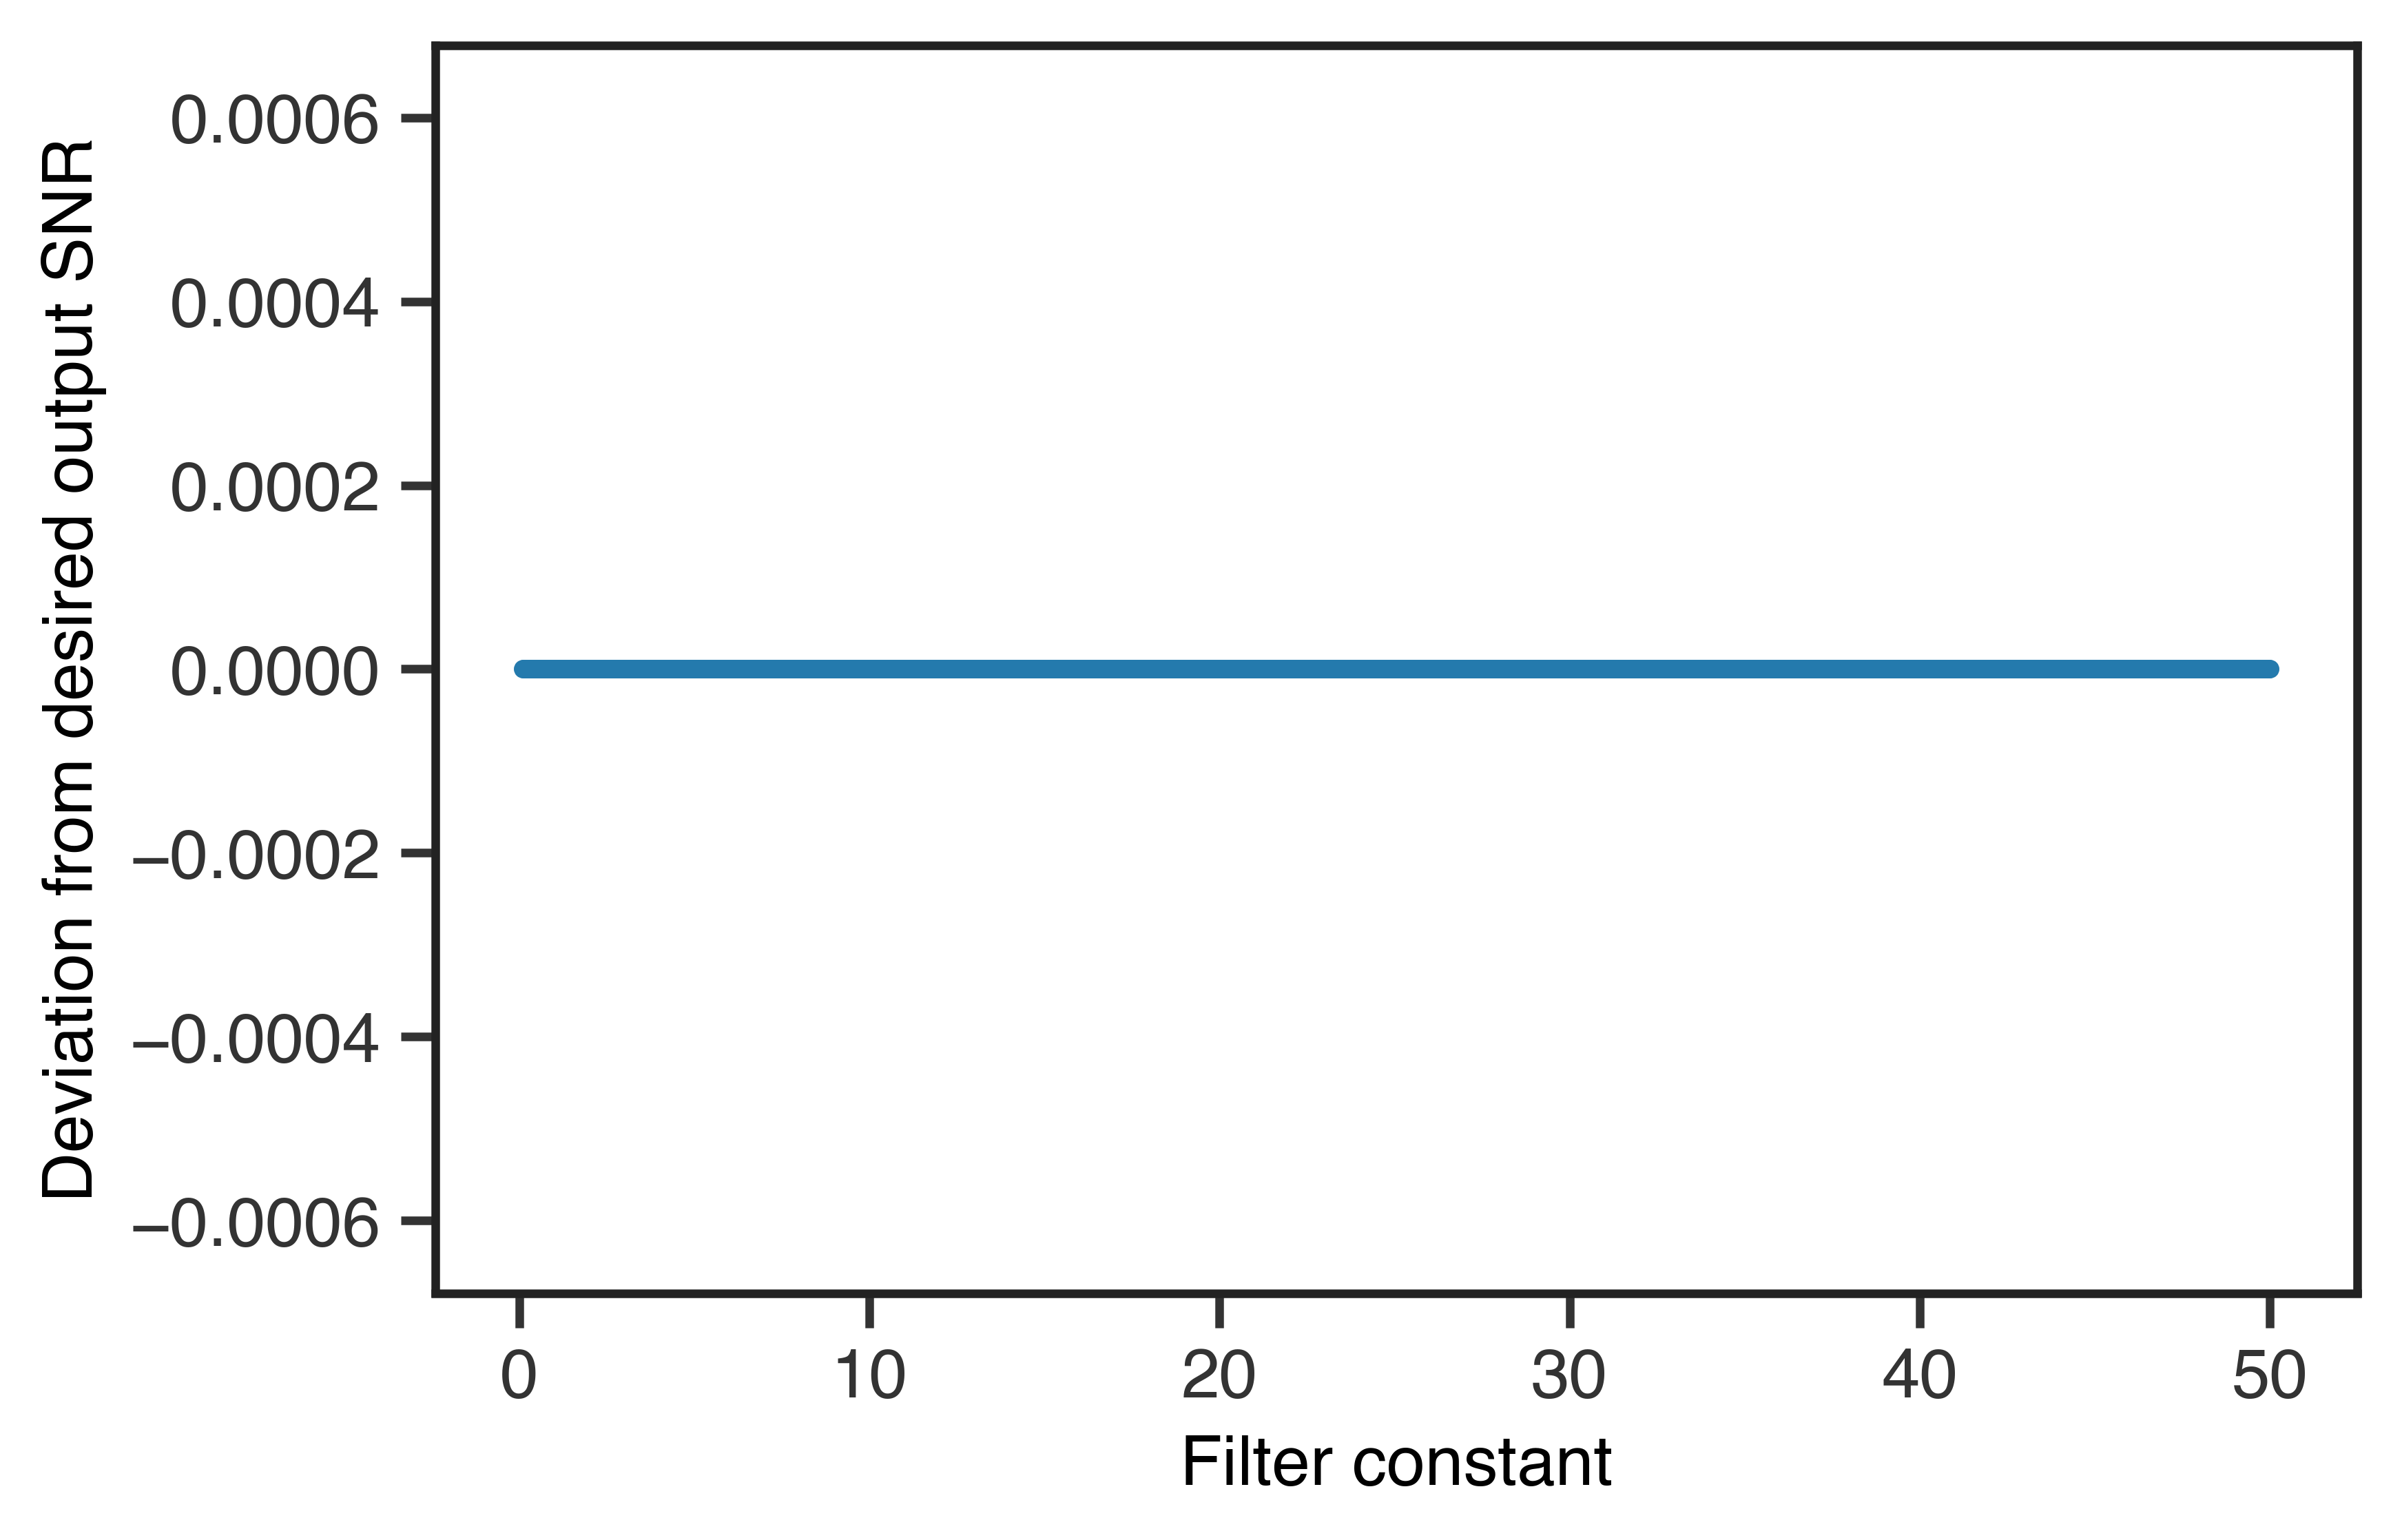

In [85]:
plt.scatter(explore_filt_consts, fit_error, s=5)
plt.ylabel('Deviation from desired output SNR')
plt.xlabel('Filter constant')

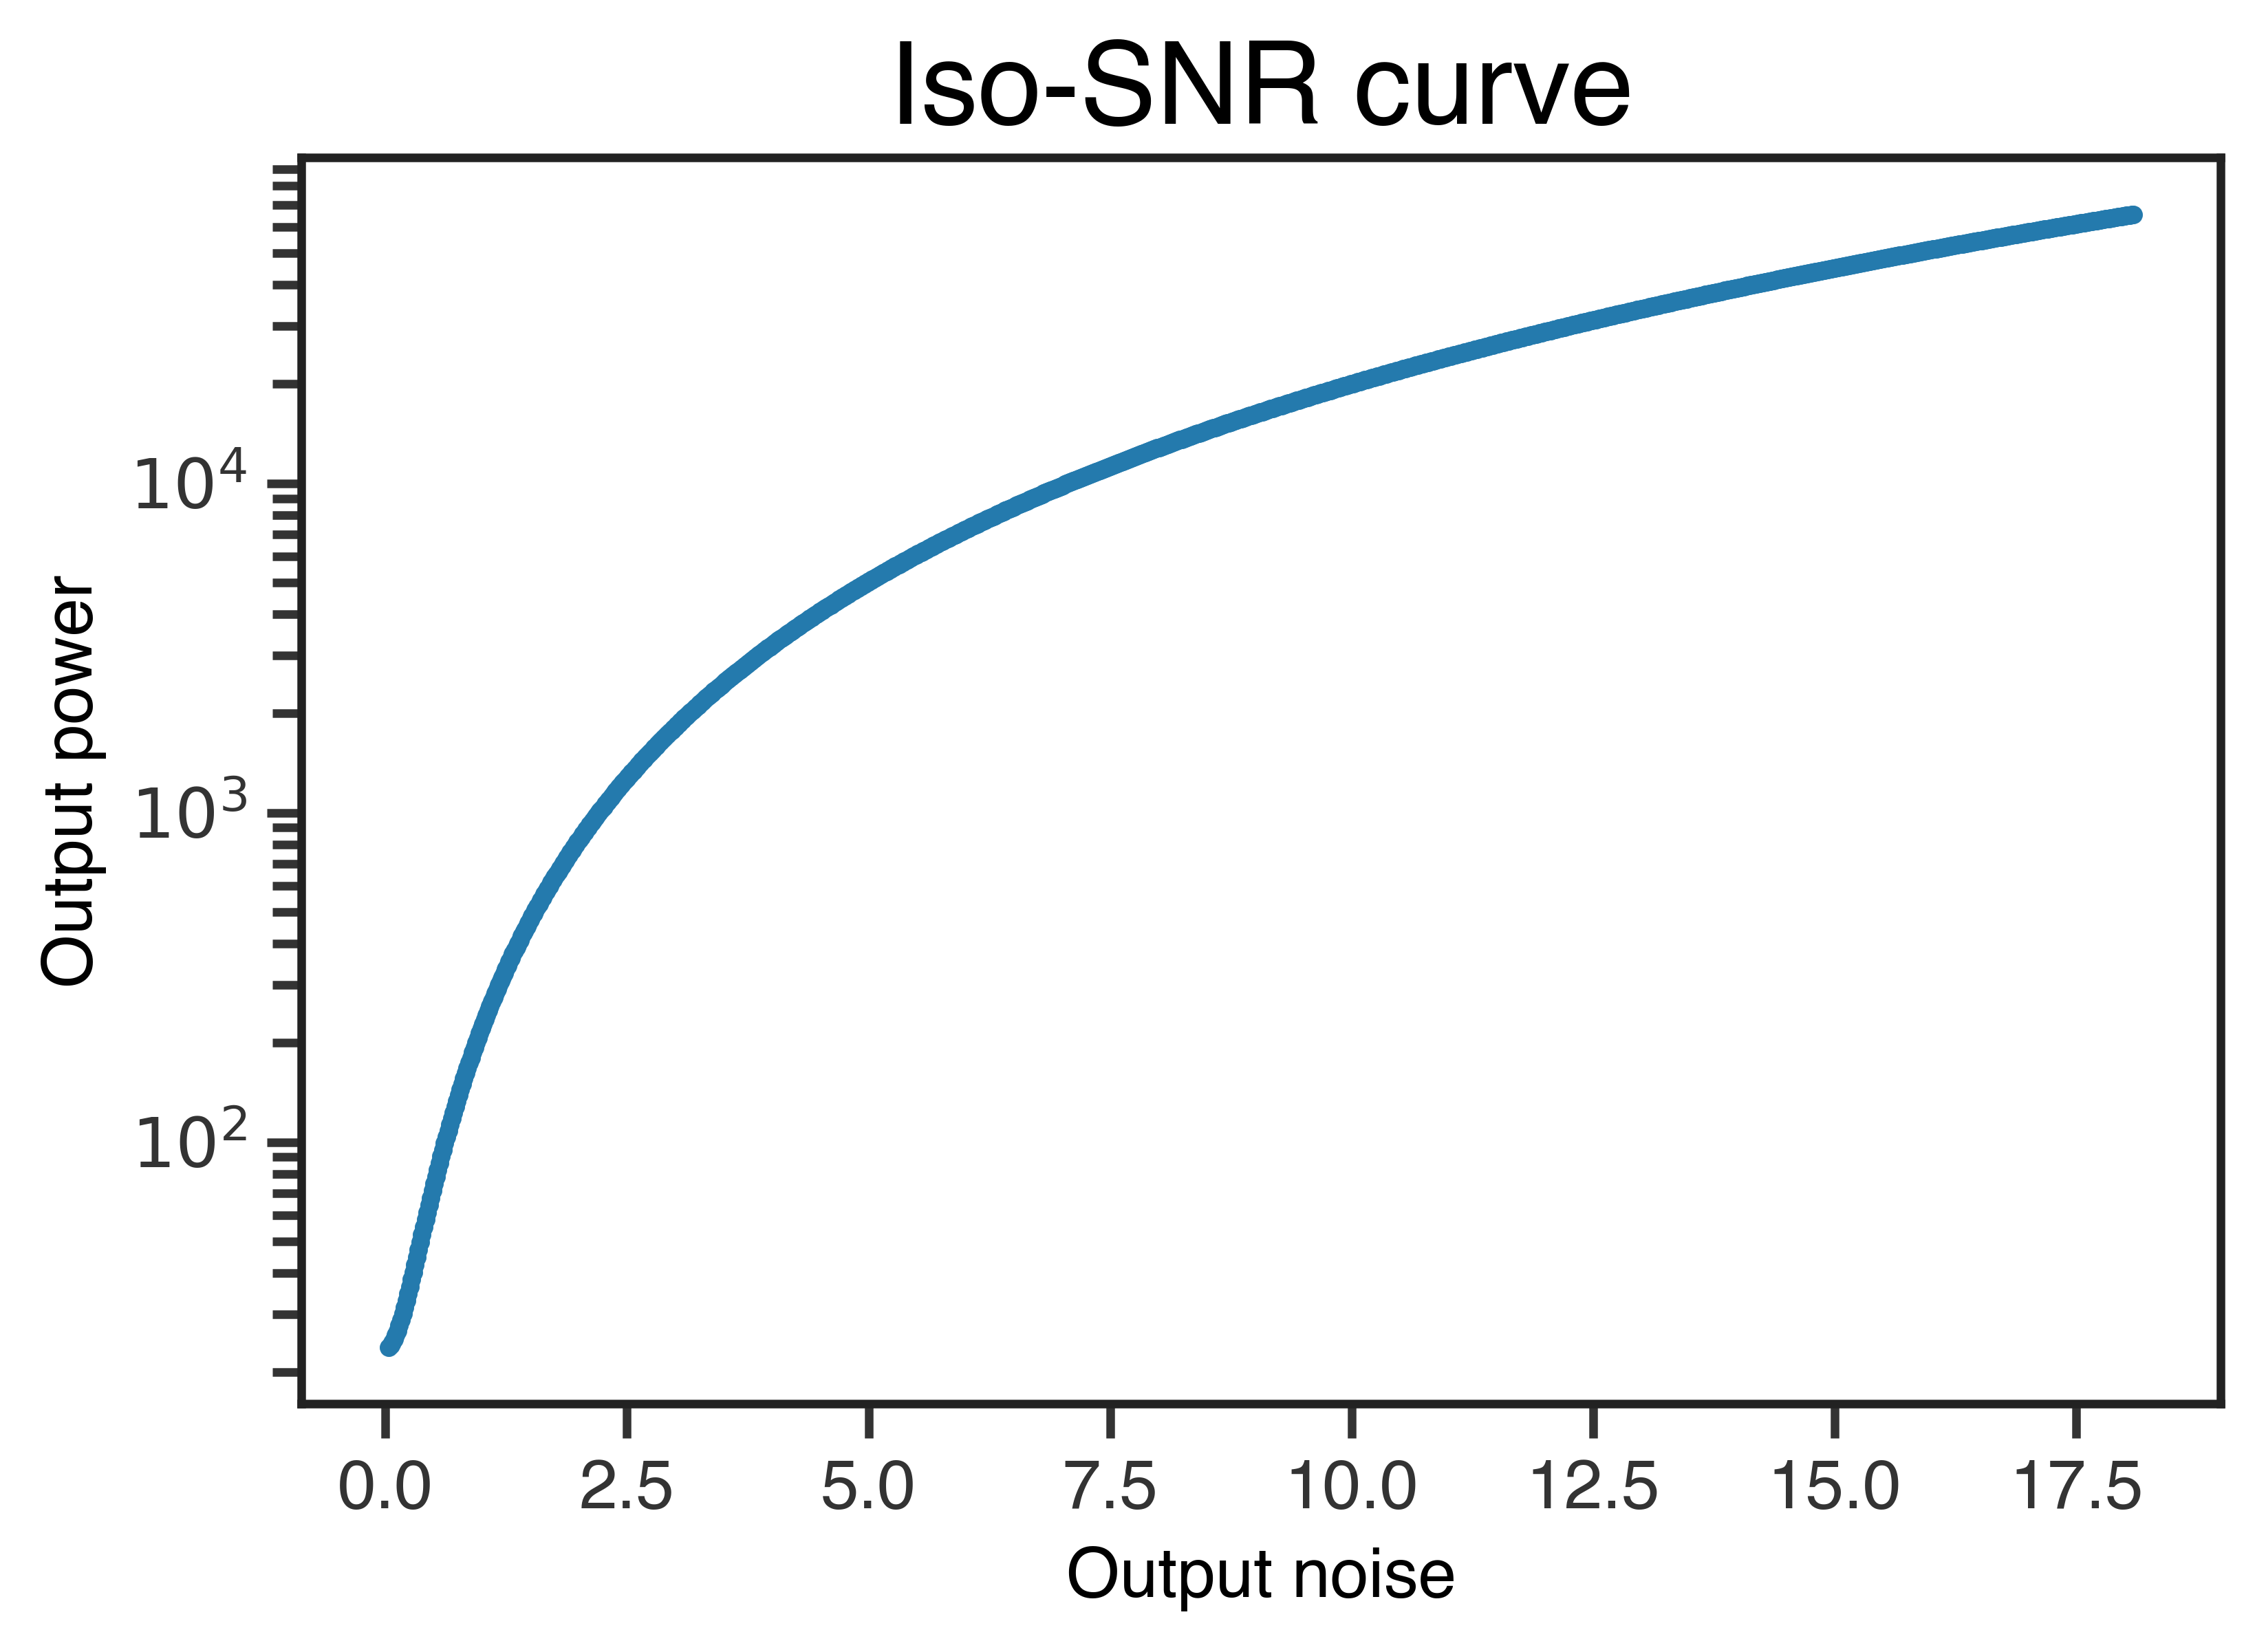

In [116]:
plt.scatter(output_noises, output_powers, s=5)
plt.ylabel('Output power')
plt.xlabel('Output noise')
plt.title('Iso-SNR curve')
plt.yscale('log')

In [89]:
explore_filt_consts[199]

10.040040040040038

In [90]:
output_noises[199]

3.6328254579628236

In [92]:
output_powers[199]

2663.0375271076723

In [91]:
input_noise

0.046925374164122881

In [93]:
output_noise = output_noises[199]
target_power = output_powers[199]

8.50412284433


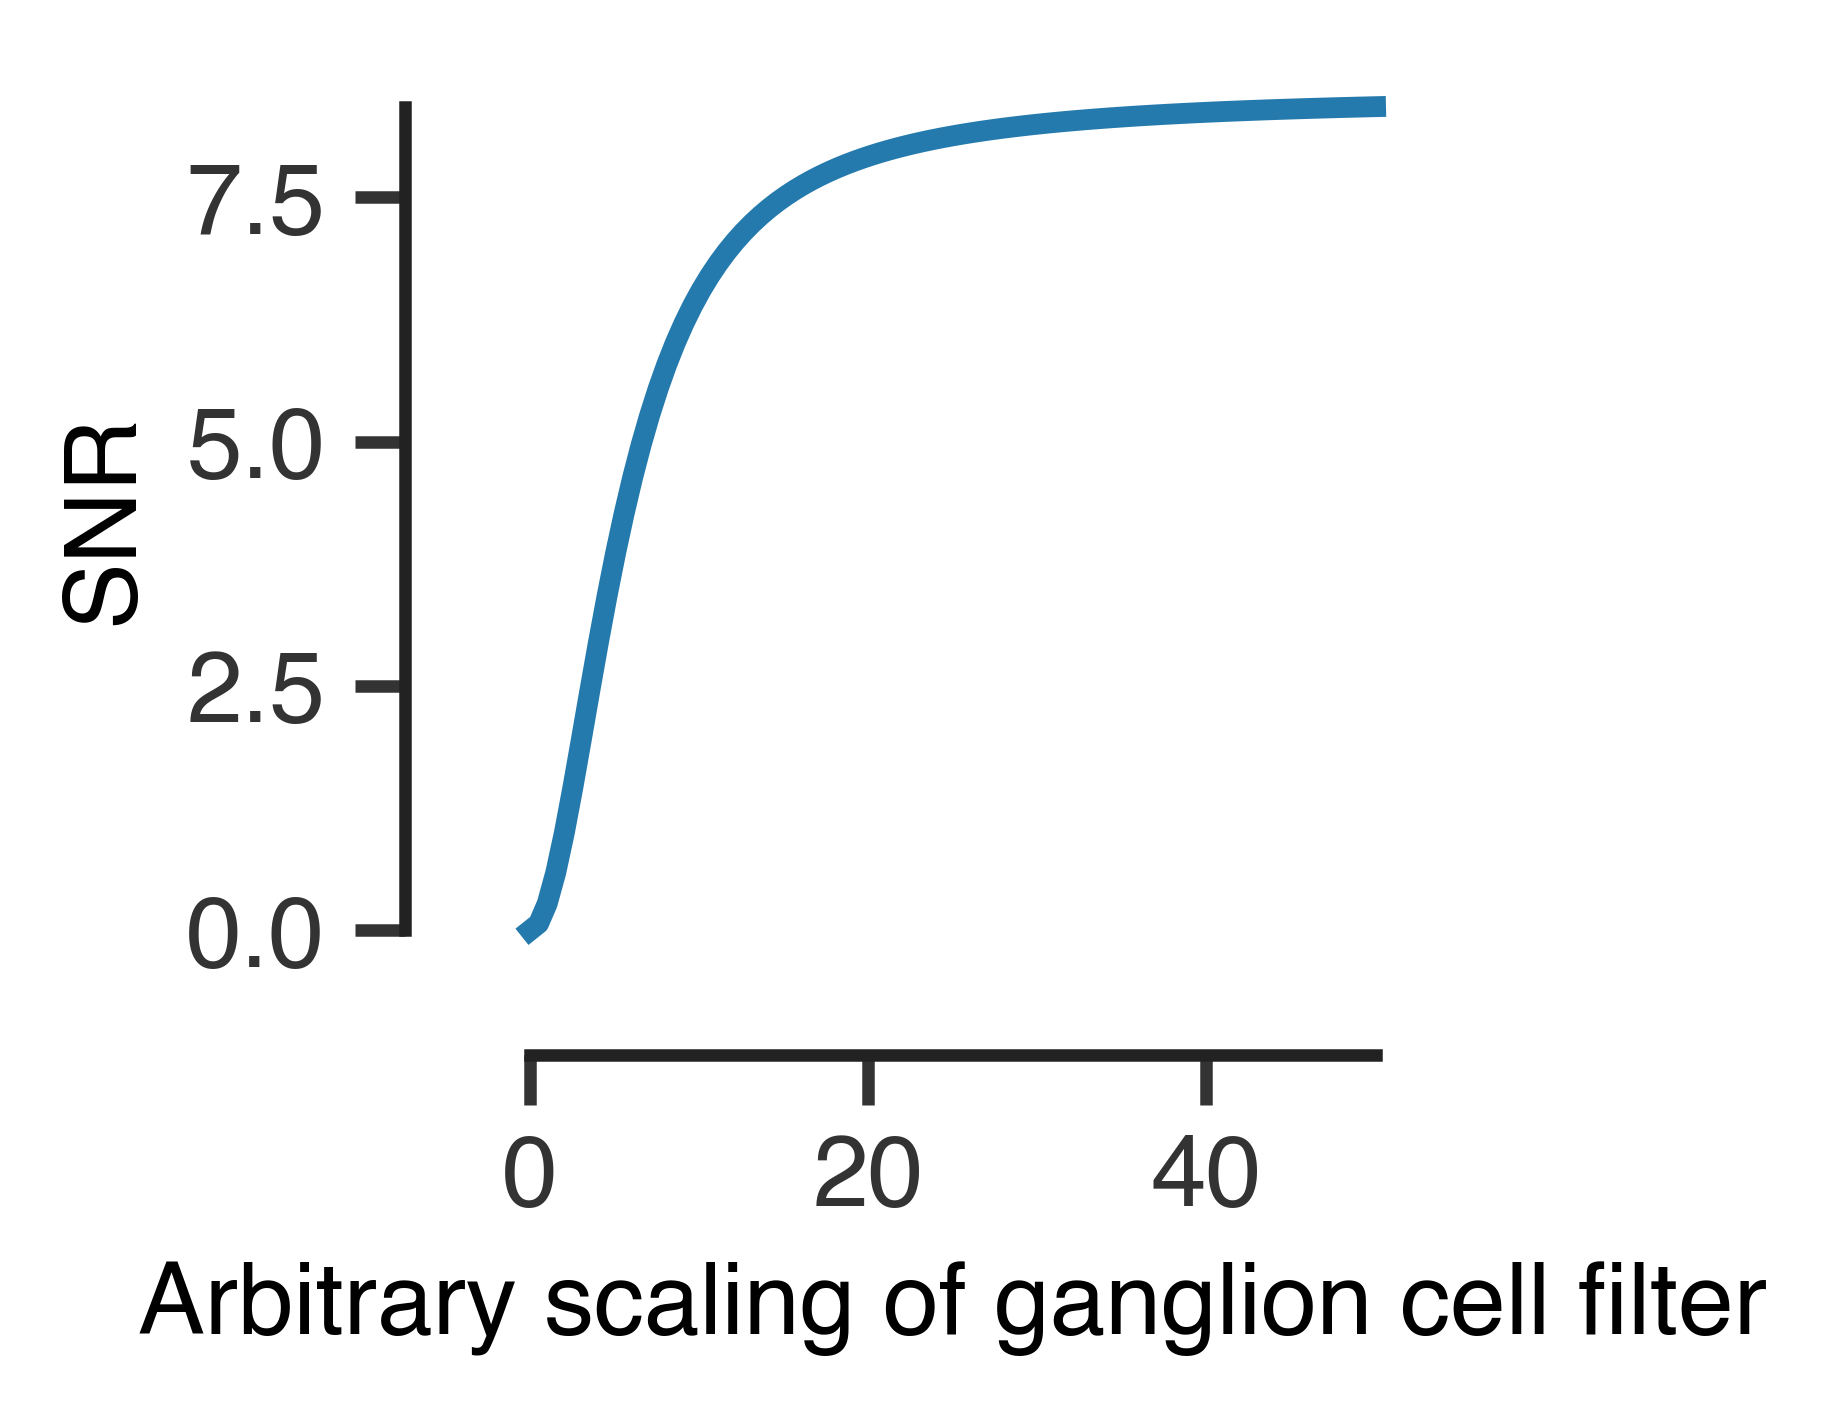

In [96]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,500,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [99]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

0it [00:00, ?it/s]/home/lane/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lane/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  9.79it/s]/home/lane/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
249it [00:00, 929.57it/s]
321it [00:00, 3568.87it/s]
253it [00:00, 3751.27it/s]
772it [00:00, 2954.64it/s]
28it [00:00, 3953.96it/s]
126it [00:00, 3809.62it/s]


In [100]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

/home/lane/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [101]:
resolution = 150
horz_weights = [0.5]
center_weights = np.linspace(0,1,resolution)

celltype = 'fast_on'
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
snrs = collections.defaultdict(list)

input_noises = [0.03228, 0.04691, 0.0987, 0.1965] #np.array([np.float('%0.2f' %x) for x in np.logspace(-2, 0, 10)])
# output_noises = [0.35] #np.array([np.float('%0.2f' %x) for x in [0.1, 0.35, 0.8]])
# powers = np.round(np.linspace(1.,200,4))
# target_power = 54.131410989171826
for input_noise in tqdm(input_noises):
#     for output_noise in output_noises:
    center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

#         print('Information map for %s cells.' %celltype)

    infomap = np.zeros((resolution,))
    hw = horz_weights[0]
    these_snrs = []
    for idc,cw in enumerate(center_weights):
        rf = rf_model(hw, cw)
        rf_filt = abs(np.fft.rfft(rf))

        # constrain model
        def constrain_filt_power(filt_const):
            size = len(rf_filt)
            output_power = np.sum((signal*filt_const*rf_filt)**2 
                                  + (input_noise*filt_const*rf_filt)**2
                                  + output_noise**2)

            return (target_power - output_power)**2

        filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
        iterations = 0
        new_init_filt_const = init_filt_const
        while not filt_const_opt.success:
            iterations += 1
            new_init_filt_const *= 10
            filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
            if iterations > 10:
                detailed_failures[celltype] = filt_const_opt
                break

        filt_const = abs(filt_const_opt['x'])

        if not filt_const_opt.success:
            failures[celltype].append([hw, cw])

        signal_power = (filt_const * rf_filt * signal)**2
        noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
        infomap[idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
#             these_snrs.append(np.sum(signal_power)/np.sum(noise_power))
        #these_snrs.append(get_snr(input_noise, output_noise, signal, filt_const * rf_filt))
        #these_snrs.append(np.sum(signal_power/noise_power))
        #these_snrs.append(np.sum(signal_power)/np.sum(noise_power))
        #signal_vars = get_signal_var(signal, filt_const*rf_filt, total_var=False)
        #noise_vars = get_noise_var(input_noise, output_noise, filt_const*rf_filt, total_var=False)
        #these_snrs.append(np.sum(signal_vars/noise_vars))
        these_snrs.append(np.sum(signal**2)/np.sum((input_noise*np.ones_like(signal))**2))
    info_maps['%0.2f, %0.2f, %0.2f' %(input_noise, output_noise, target_power)] = infomap
    snrs['%0.2f, %0.2f, %0.2f' %(input_noise, output_noise, target_power)] = np.array(these_snrs)

  0%|          | 0/4 [00:00<?, ?it/s]/home/lane/.local/lib/python3.5/site-packages/scipy/optimize/optimize.py:157: RuntimeWarning: invalid value encountered in absolute
  return numpy.amax(numpy.abs(x))
100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


In [103]:
info_maps.keys()

dict_keys(['0.20, 3.63, 2663.04', '0.10, 3.63, 2663.04', '0.05, 3.63, 2663.04', '0.03, 3.63, 2663.04'])

In [104]:
key

'0.03, 3.63, 2663.04'

In [112]:
noise_power

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [109]:
filt_const

array([  1.09000000e+12])

In [107]:
info_maps[key]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])

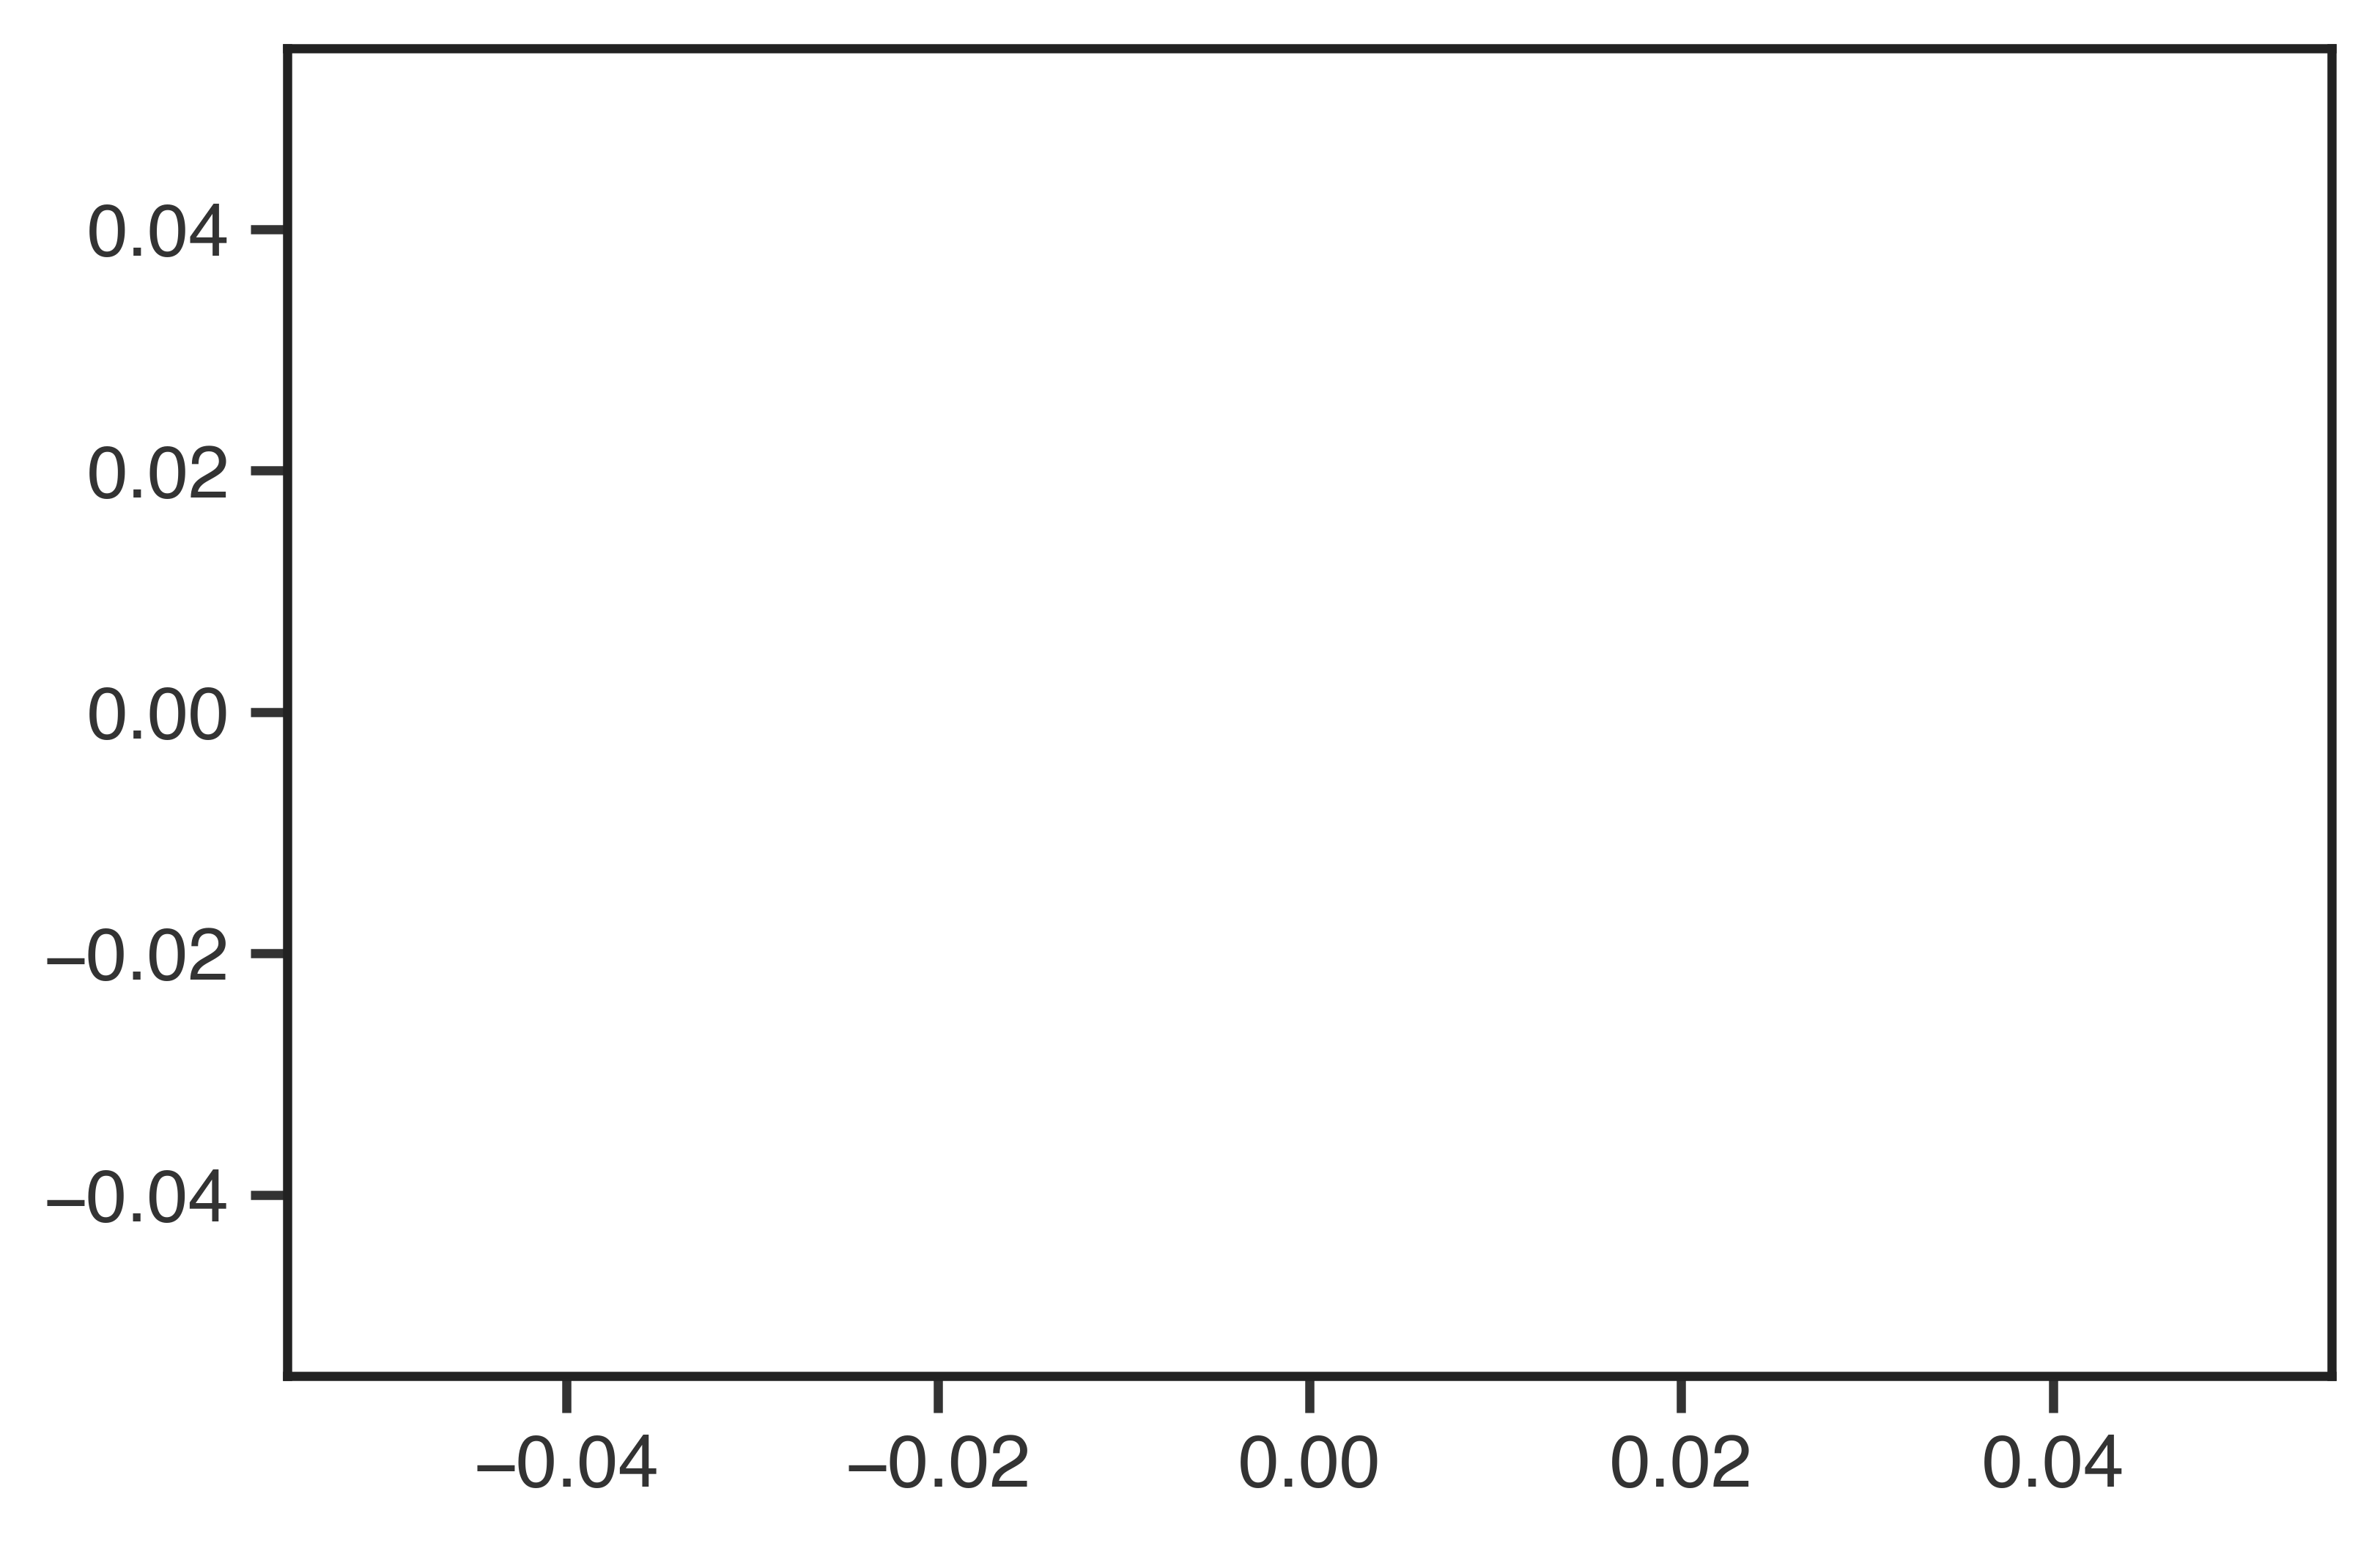

In [106]:
plt.plot(center_weights, info_maps[key])

In [102]:
for key in info_maps.keys():
    if np.max(info_maps[key]) > 10e-2:
        input_noise, output_noise, target_power = [float(x) for x in key.split(',')]
        this_random_color = (1-input_noise, output_noise, 1.) #np.random.rand(3)
        plt.plot(center_weights, info_maps[key], alpha=0.3, color=this_random_color)
        plt.plot(center_weights, our_info_map, color='k')
    #     plt.vlines(center_weights[np.argmax(info_maps[key])], 0, 60, color=this_random_color, alpha=0.5)
        if np.argmax(info_maps[key]) > 100:
            print('%s, optimal cw = %0.2f' %(key, center_weights[np.argmax(info_maps[key])]))
        plt.scatter(center_weights[np.argmax(info_maps[key])], np.max(info_maps[key]), color='k', s=30, alpha=0.5,
                   edgecolor='w')
        plt.text(center_weights[np.argmax(info_maps[key])]+.01, np.max(info_maps[key])+0.3,
                 str('%0.2f' %np.max(snrs[key])), color='k', fontsize=8)
# plt.yscale('log')
# plt.ylim(1e-2, 40)
adjust_spines(plt.gca())
plt.scatter(.8, 14, color='k', s=10, alpha=.5)
plt.text(.81, 14+.3, 'Input \nSNRs', color='k', fontsize=8)
plt.xlabel('Center width', fontsize=20)
plt.ylabel('Information (bits)', fontsize=20)

ValueError: Image size of 24839x284757 pixels is too large. It must be less than 2^16 in each direction.